## Feature_Importance

* Mi scores and Correlation plots
* Scatterplots (lim and rel plots)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

In [3]:
from IPython.display import display
from sklearn.metrics import mutual_info_score

In [4]:
from dython.nominal import associations

In [5]:
train = pd.read_csv('train.csv')
print(train.shape)
train.head().T

(1460, 81)


0       1       2        3       4
Id                  1       2       3        4       5
MSSubClass         60      20      60       70      60
MSZoning           RL      RL      RL       RL      RL
LotFrontage      65.0    80.0    68.0     60.0    84.0
LotArea          8450    9600   11250     9550   14260
...               ...     ...     ...      ...     ...
MoSold              2       5       9        2      12
YrSold           2008    2007    2008     2006    2008
SaleType           WD      WD      WD       WD      WD
SaleCondition  Normal  Normal  Normal  Abnorml  Normal
SalePrice      208500  181500  223500   140000  250000

[81 rows x 5 columns]

In [6]:
test = pd.read_csv('test.csv')
print(test.shape)
test.head().T

(1459, 80)


0       1       2       3       4
Id               1461    1462    1463    1464    1465
MSSubClass         20      20      60      60     120
MSZoning           RH      RL      RL      RL      RL
LotFrontage      80.0    81.0    74.0    78.0    43.0
LotArea         11622   14267   13830    9978    5005
...               ...     ...     ...     ...     ...
MiscVal             0   12500       0       0       0
MoSold              6       6       3       6       1
YrSold           2010    2010    2010    2010    2010
SaleType           WD      WD      WD      WD      WD
SaleCondition  Normal  Normal  Normal  Normal  Normal

[80 rows x 5 columns]

In [7]:
cats_train = train.select_dtypes(include='object').columns
cats_test = test.select_dtypes(include='object').columns
print('No of train cat_cols : ',len(cats_train))
print('No of test cat_cols : ',len(cats_test))

No of train cat_cols :  43
No of test cat_cols :  43


In [8]:
nums_train = train.select_dtypes(exclude='object').columns
nums_test = test.select_dtypes(exclude='object').columns
print('No of train cat_cols : ',len(nums_train))
print('No of test cat_cols : ',len(nums_test))

No of train cat_cols :  38
No of test cat_cols :  37


In [9]:
num_cat = ['MSSubClass','OverallQual','OverallCond','BsmtFullBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
           'TotRmsAbvGrd','Fireplaces','GarageCars','MoSold','YrSold',]

In [17]:
def plot_mutual_info_and_corr(df,cols,target_col,fill_na):
    df_def = df.copy()
    df_def = df_def.fillna(fill_na)
    def make_log(df_def,drop_target=False):
        df_log = df.copy()
        num_cols = df_log.select_dtypes(exclude='object').columns
        if drop_target == True:
            num_cols = num_cols.drop(target_col)
        numeric = df_log.select_dtypes(exclude='object')
        for col in num_cols:
            numeric.loc[:,col] = np.log(numeric[col]+1)
        return numeric 
    logged = make_log(df_def)
    
    #display(df_def.info())
    
    def mutual_info_price_score(series):
        return mutual_info_score(series,df_def[target_col])
    
    mi_normal = df_def[cols].apply(mutual_info_price_score)
    #mi_logged = logged[cols].apply(mutual_info_price_score)
    
    #display(mi_normal.sort_values(ascending=False))
    
    features = mi_normal.sort_values(ascending=False).index.to_list()
    scores = mi_normal.sort_values(ascending=False).values
    #correlation
    correlation = df_def[cols].corrwith(df_def[target_col])
    mi_corr_df = pd.DataFrame(scores,index=features,columns=['mi_score'])
    mi_corr_df['Corr_Score']= [correlation[col] for col in features ]
    
    #display(correlation)
    print()
    display(mi_corr_df)
    for col,score in zip(features,scores):
        print(col)
        print("Mi Score: ",score,"  || Corr Score: ",correlation[col])
        plt.subplot(1, 2, 1)
        sns.scatterplot(x=col, y="SalePrice", data=df_def)
        plt.title("Normal train Scatter")
        
        plt.subplot(1, 2, 2)
        sns.scatterplot(x=col, y="SalePrice", data=logged)
        plt.title("logged train Scatter")
        plt.tight_layout()
        
        sns.lmplot(x=col, y="SalePrice", data=df_def)
        plt.title(" train lmplot")
        
        sns.lmplot(x=col, y="SalePrice", data=logged)
        plt.title("logged lmplot")
       
        plt.tight_layout()
        plt.show()
        print()
        print()

In [46]:
def mi_score_and_corr_num_cat(df,cols,target_col,fill_na):
    df_def = df.copy()
    df_def = df_def.fillna(fill_na)
    
    def mutual_info_price_score(series):
        return mutual_info_score(series,df_def[target_col])
    
    mi_normal = df_def[cols].apply(mutual_info_price_score)
    features = mi_normal.sort_values(ascending=False).index.to_list()
    scores = mi_normal.sort_values(ascending=False).values

    corr_num_cat = associations(dataset=df_def[(cols +[target_col])],numerical_columns=target_col,nan_replace_value=fill_na,cmap='viridis',mark_columns=False,ax=None,compute_only=True)
    mi_corr_df = pd.DataFrame(scores,index=features,columns=['mi_score'])
    mi_corr_df['Corr_Score']= [corr_num_cat['corr'][target_col][col]  for col in features ]
    
    
    display(mi_corr_df)
    
    print()
    plt.rc("figure",figsize=(12,6))
    X_axis = np.arange(0,mi_corr_df.shape[0])
    max_mi_score = mi_corr_df['mi_score'].max() # since correlation is always <=1 ..for better visualization we normalize
    min_mi_score = mi_corr_df['mi_score'].min()
    norm_mi_score = (mi_corr_df['mi_score'] - min_mi_score)/(max_mi_score-min_mi_score)
    plt.bar(X_axis,norm_mi_score,label='Mi_score',width=0.3)
    plt.bar(X_axis + 0.3,mi_corr_df['Corr_Score'],label='Corr_Score',width=0.25)
    ticks = X_axis # points on the x axis where you want the label to appear
    labels=mi_corr_df.index
    plt.xticks(ticks, labels);
    ax = plt.gca()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.title("Mi Score and Correlation Score")
    plt.legend()
    plt.show()
    
    return mi_corr_df
    
         

In [15]:
def mi_score_and_corr_continous(df,cols,target_col,fill_na):
    df_def = df.copy()
    df_def = df_def.fillna(fill_na)
    
    def mutual_info_price_score(series):
        return mutual_info_score(series,df_def[target_col])
    
    mi_normal = df_def[cols].apply(mutual_info_price_score)
    features = mi_normal.sort_values(ascending=False).index.to_list()
    scores = mi_normal.sort_values(ascending=False).values

    correlation = df_def[cols].corrwith(df_def[target_col])
    mi_corr_df = pd.DataFrame(scores,index=features,columns=['mi_score'])
    mi_corr_df['Corr_Score']= [correlation[col] for col in features ]
    
    display(mi_corr_df)
    
    print()
    plt.rc("figure",figsize=(12,6))
    X_axis = np.arange(0,mi_corr_df.shape[0])
    max_mi_score = mi_corr_df['mi_score'].max() # since correlation is always <=1 ..for better visualization we normalize
    min_mi_score = mi_corr_df['mi_score'].min()
    norm_mi_score = (mi_corr_df['mi_score'] - min_mi_score)/(max_mi_score-min_mi_score)
    plt.bar(X_axis,norm_mi_score,label='Mi_score',width=0.3)
    plt.bar(X_axis + 0.3,mi_corr_df['Corr_Score'],label='Corr_Score',width=0.25)
    ticks = X_axis # points on the x axis where you want the label to appear
    labels=mi_corr_df.index
    plt.xticks(ticks, labels);
    ax = plt.gca()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.title("Mi Score and Correlation Score")
    plt.legend()
    plt.show()
    
    return mi_corr_df
    
         

## Num Cat

mi_score  Corr_Score
MoSold        1.422846    0.046432
MSSubClass    1.281812   -0.084284
OverallQual   1.175989    0.790982
TotRmsAbvGrd  1.166100    0.533723
YrSold        0.847030   -0.028923
GarageCars    0.755562    0.640409
OverallCond   0.742182   -0.077856
BedroomAbvGr  0.685355    0.168213
FullBath      0.549952    0.560664
Fireplaces    0.543726    0.466929
HalfBath      0.379421    0.284108
BsmtFullBath  0.354872    0.227122
KitchenAbvGr  0.119028   -0.135907

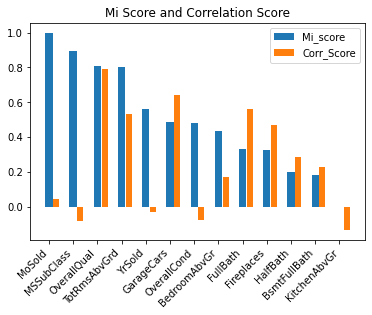

mi_score  Corr_Score
MoSold        1.422846    0.046432
MSSubClass    1.281812   -0.084284
OverallQual   1.175989    0.790982
TotRmsAbvGrd  1.166100    0.533723
YrSold        0.847030   -0.028923
GarageCars    0.755562    0.640409
OverallCond   0.742182   -0.077856
BedroomAbvGr  0.685355    0.168213
FullBath      0.549952    0.560664
Fireplaces    0.543726    0.466929
HalfBath      0.379421    0.284108
BsmtFullBath  0.354872    0.227122
KitchenAbvGr  0.119028   -0.135907

In [21]:
mi_score_and_corr_continous(df=train,cols=num_cat,target_col='SalePrice',fill_na=0)

mi_score  Corr_Score
MoSold        1.422846    0.084994
MSSubClass    1.281812    0.496302
OverallQual   1.175989    0.827153
TotRmsAbvGrd  1.166100    0.546867
YrSold        0.847030    0.042089
GarageCars    0.755562    0.700877
OverallCond   0.742182    0.354105
BedroomAbvGr  0.685355    0.242193
FullBath      0.549952    0.580028
Fireplaces    0.543726    0.481828
HalfBath      0.379421    0.304537
BsmtFullBath  0.354872    0.231361
KitchenAbvGr  0.119028    0.140936

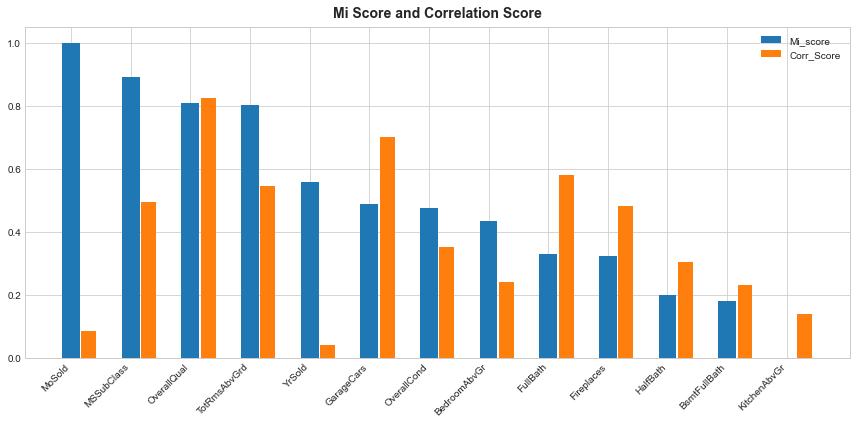

In [47]:
mi_score_num_cat = mi_score_and_corr_num_cat(df=train,cols=num_cat,target_col='SalePrice',fill_na=0)

mi_score  Corr_Score
MoSold        1.422846    0.046432
MSSubClass    1.281812   -0.084284
OverallQual   1.175989    0.790982
TotRmsAbvGrd  1.166100    0.533723
YrSold        0.847030   -0.028923
GarageCars    0.755562    0.640409
OverallCond   0.742182   -0.077856
BedroomAbvGr  0.685355    0.168213
FullBath      0.549952    0.560664
Fireplaces    0.543726    0.466929
HalfBath      0.379421    0.284108
BsmtFullBath  0.354872    0.227122
KitchenAbvGr  0.119028   -0.135907

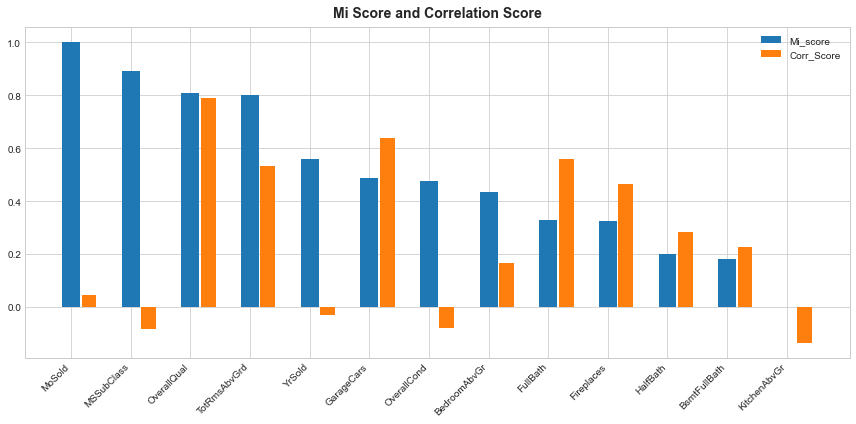

mi_score  Corr_Score
MoSold        1.422846    0.046432
MSSubClass    1.281812   -0.084284
OverallQual   1.175989    0.790982
TotRmsAbvGrd  1.166100    0.533723
YrSold        0.847030   -0.028923
GarageCars    0.755562    0.640409
OverallCond   0.742182   -0.077856
BedroomAbvGr  0.685355    0.168213
FullBath      0.549952    0.560664
Fireplaces    0.543726    0.466929
HalfBath      0.379421    0.284108
BsmtFullBath  0.354872    0.227122
KitchenAbvGr  0.119028   -0.135907

In [120]:
mi_score_and_corr(df=train,cols=num_cat,target_col='SalePrice',fill_na=0)

### Base numcat features
    We wanna select features with high correlation score and satisfory mi_score

In [54]:
thresh_corr = 0.3
mi_score_num_cat[mi_score_num_cat.Corr_Score>=thresh_corr]

mi_score  Corr_Score
MSSubClass    1.281812    0.496302
OverallQual   1.175989    0.827153
TotRmsAbvGrd  1.166100    0.546867
GarageCars    0.755562    0.700877
OverallCond   0.742182    0.354105
FullBath      0.549952    0.580028
Fireplaces    0.543726    0.481828
HalfBath      0.379421    0.304537

In [59]:
mi_score_num_cat[mi_score_num_cat.Corr_Score>=thresh_corr].index

Index(['MSSubClass', 'OverallQual', 'TotRmsAbvGrd', 'GarageCars',
       'OverallCond', 'FullBath', 'Fireplaces', 'HalfBath'],
      dtype='object')

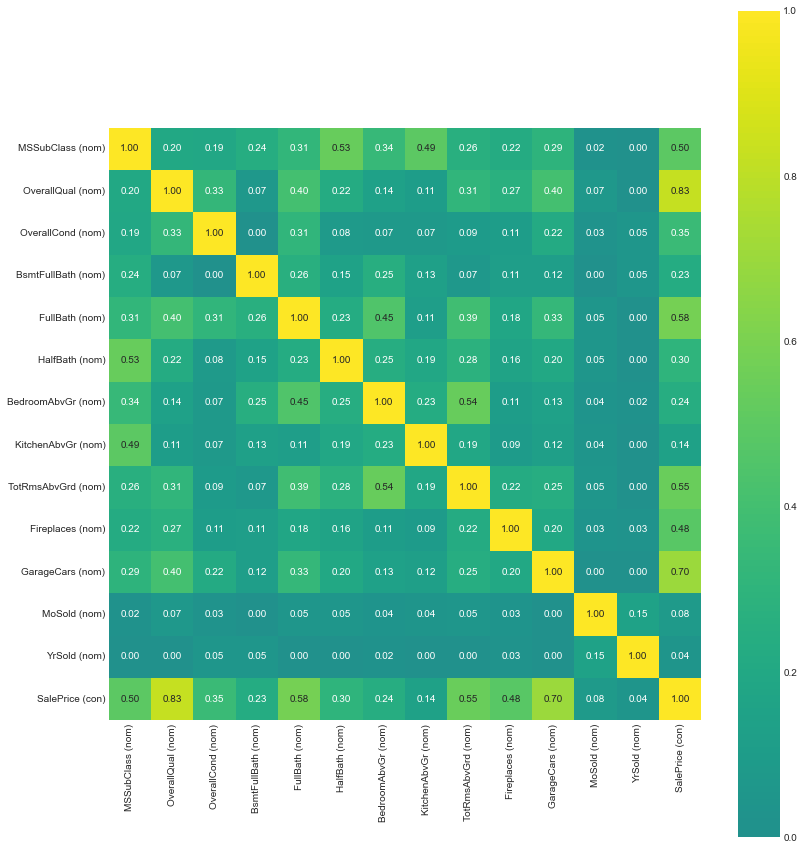

In [14]:
fig,ax = plt.subplots(figsize=(12,12))
associations(dataset=train[(num_cat +['SalePrice'])],numerical_columns='SalePrice',nan_replace_value=0,cmap='viridis',mark_columns=True,ax=ax)
fig.savefig("Num Cat kaggle house predictions.png")

mi_score  Corr_Score
MSSubClass    1.281812   -0.084284
OverallQual   1.175989    0.790982
TotRmsAbvGrd  1.166100    0.533723
GarageCars    0.755562    0.640409
OverallCond   0.742182   -0.077856
FullBath      0.549952    0.560664
Fireplaces    0.543726    0.466929
HalfBath      0.379421    0.284108

MSSubClass
Mi Score:  1.2818121163667624   || Corr Score:  -0.08428413512659517


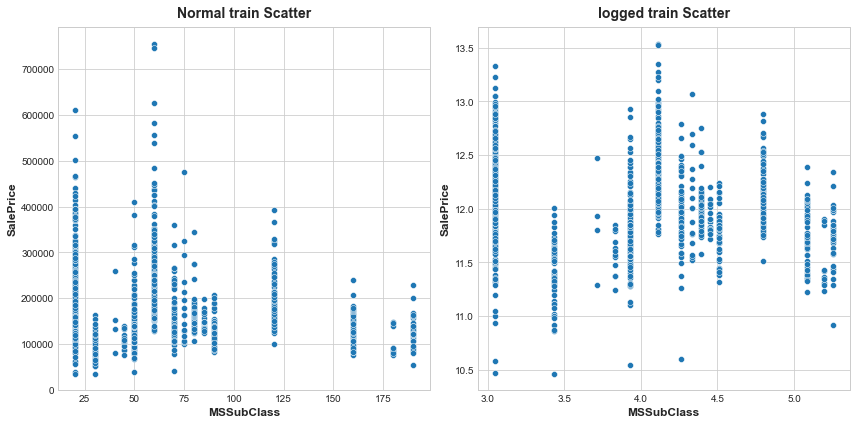

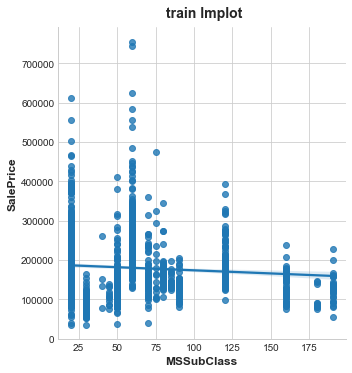

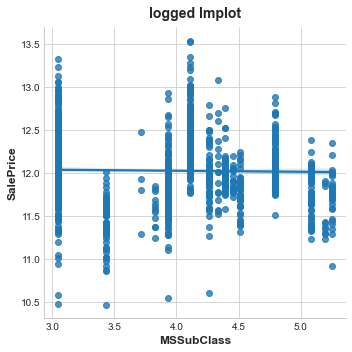



OverallQual
Mi Score:  1.1759891683036239   || Corr Score:  0.7909816005838053


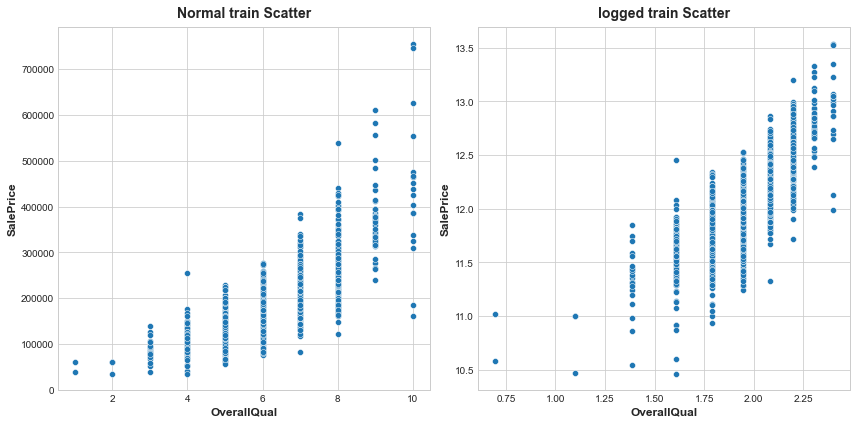

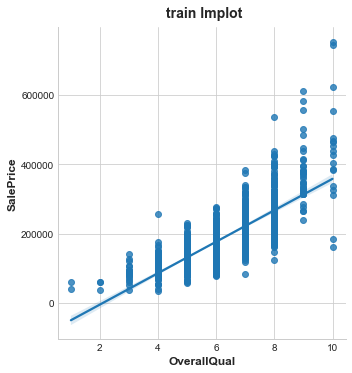

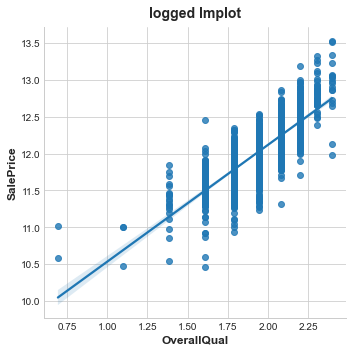



TotRmsAbvGrd
Mi Score:  1.1660998975588737   || Corr Score:  0.5337231555820281


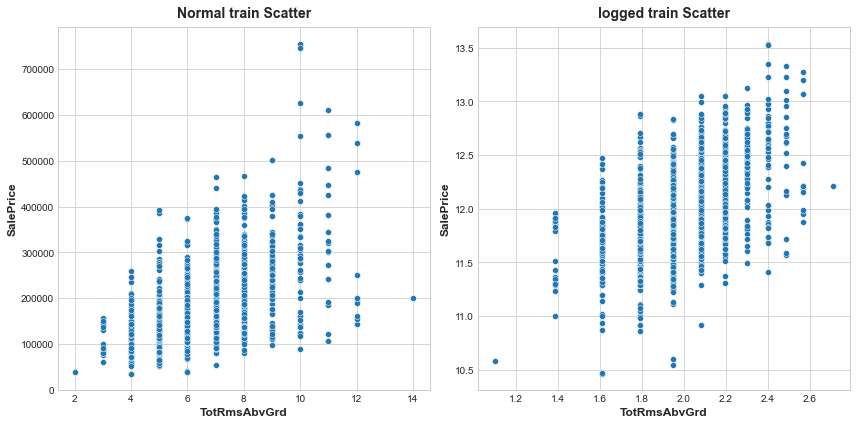

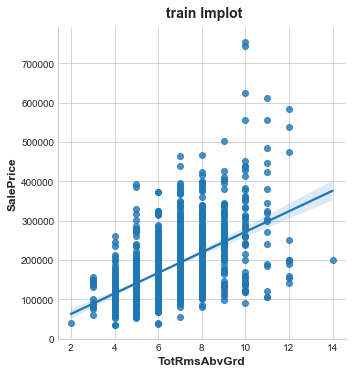

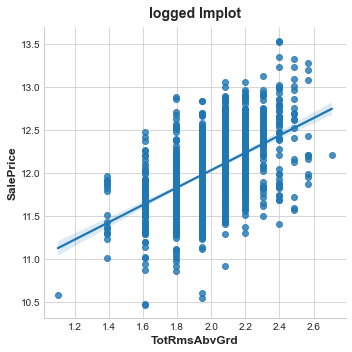



GarageCars
Mi Score:  0.7555623982260918   || Corr Score:  0.6404091972583522


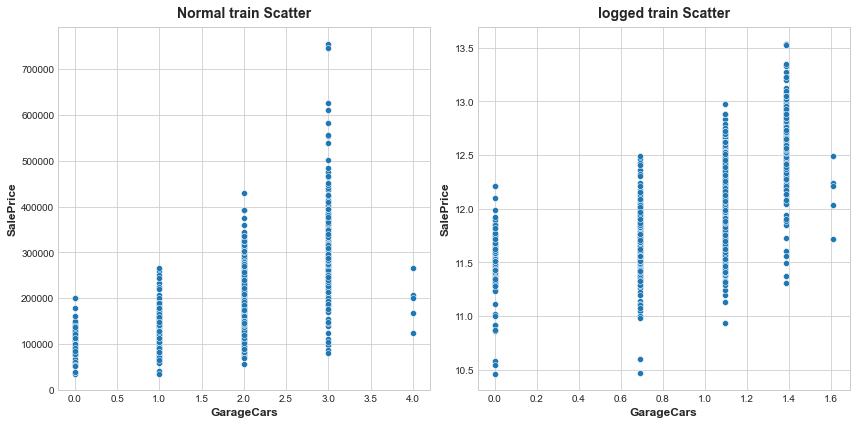

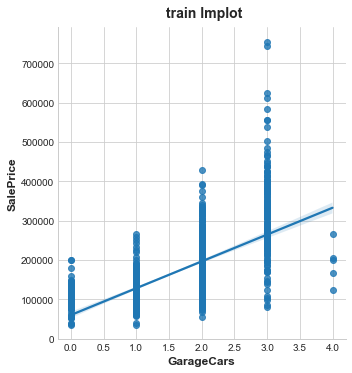

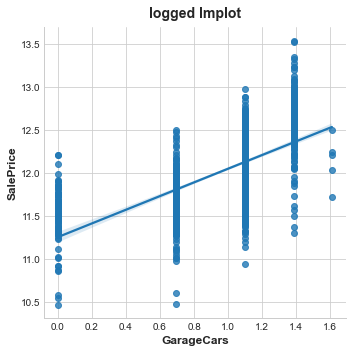



OverallCond
Mi Score:  0.7421824164050377   || Corr Score:  -0.07785589404867799


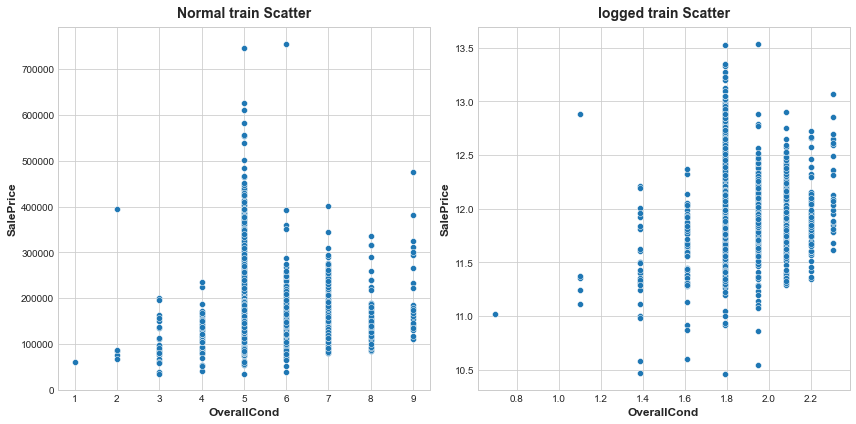

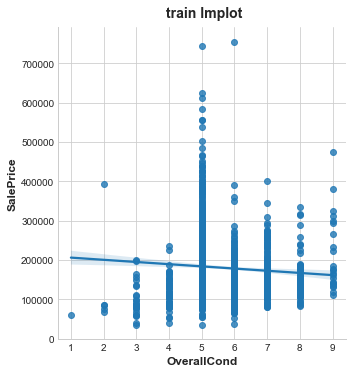

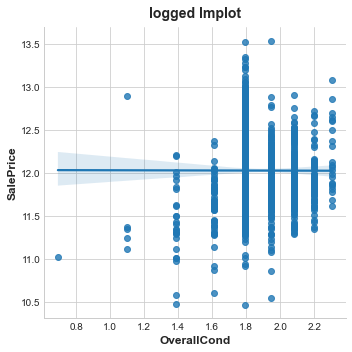



FullBath
Mi Score:  0.5499523994617983   || Corr Score:  0.5606637627484456


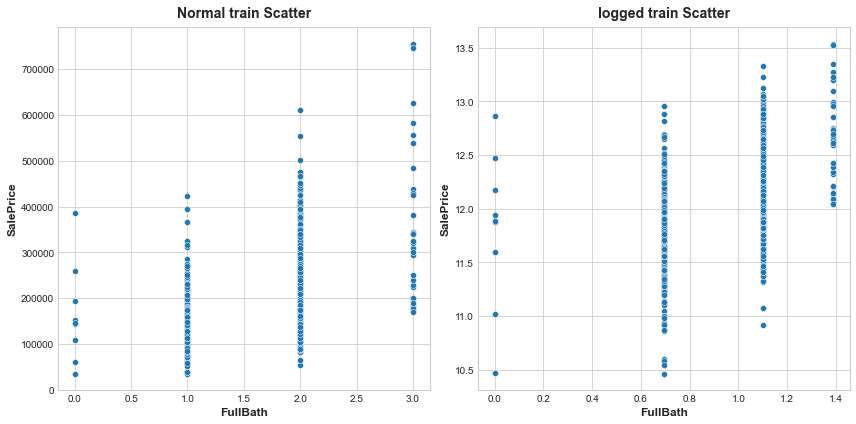

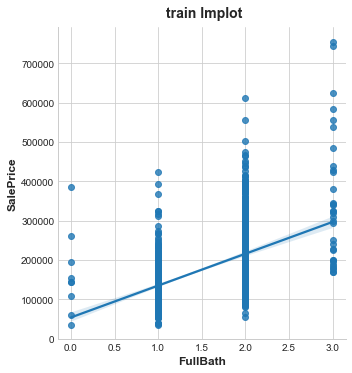

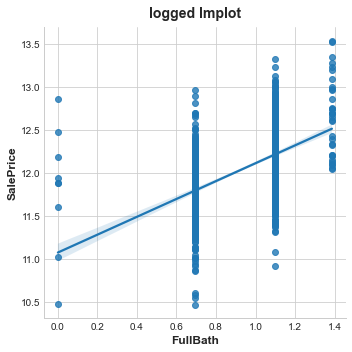



Fireplaces
Mi Score:  0.5437257069287   || Corr Score:  0.46692883675152796


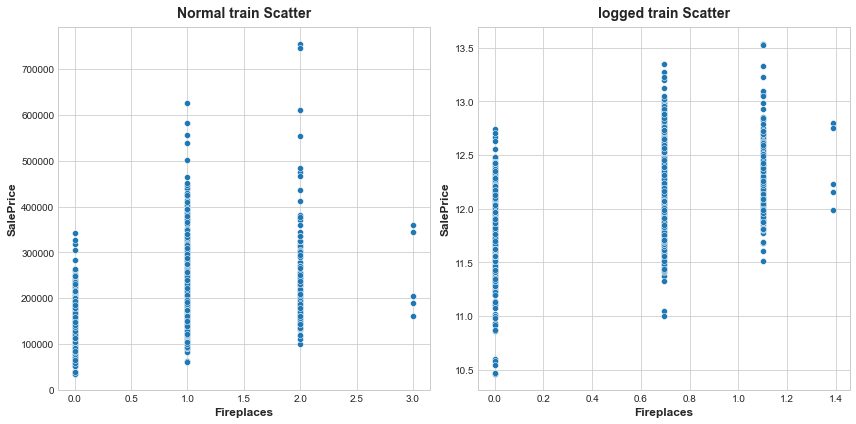

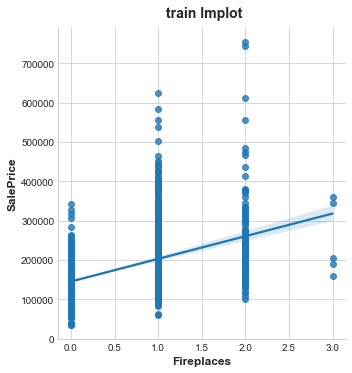

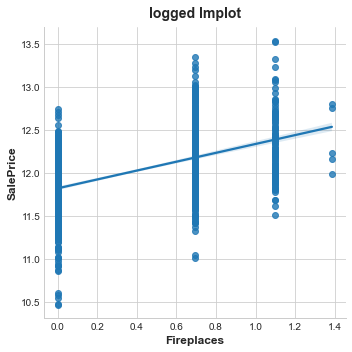



HalfBath
Mi Score:  0.3794213444601428   || Corr Score:  0.2841076755947825


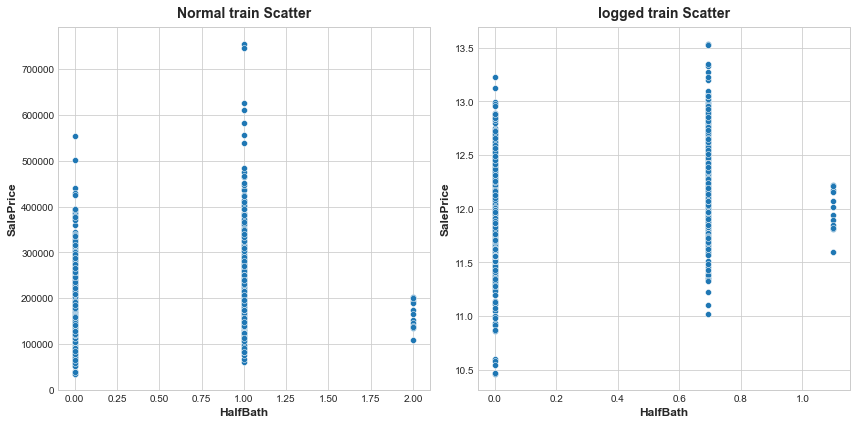

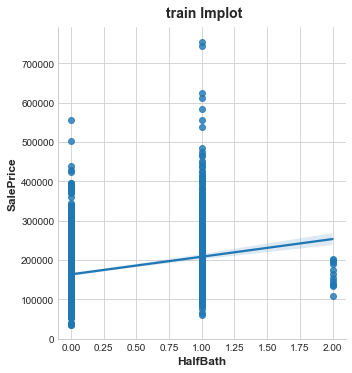

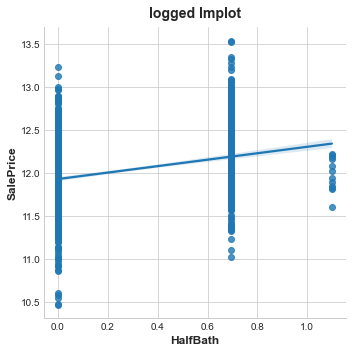

In [62]:
plot_mutual_info_and_corr(df=train,cols=mi_score_num_cat[mi_score_num_cat.Corr_Score>=thresh_corr].index,target_col='SalePrice',fill_na=-1)

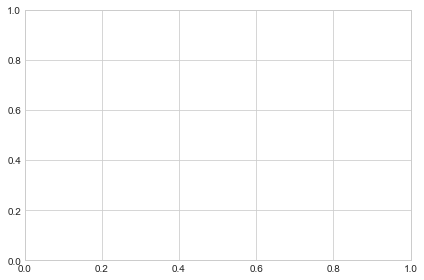

In [20]:
corr_num_cat = associations(dataset=train[(num_cat +['SalePrice'])],numerical_columns='SalePrice',nan_replace_value=0,cmap='viridis',mark_columns=False,ax=ax)

In [21]:
corr_num_cat

{'corr':               MSSubClass  OverallQual  OverallCond  BsmtFullBath  FullBath  \
 MSSubClass      1.000000     0.202211     0.189693      0.239426  0.312587   
 OverallQual     0.202211     1.000000     0.328042      0.066271  0.404457   
 OverallCond     0.189693     0.328042     1.000000      0.000000  0.309115   
 BsmtFullBath    0.239426     0.066271     0.000000      1.000000  0.263751   
 FullBath        0.312587     0.404457     0.309115      0.263751  1.000000   
 HalfBath        0.533329     0.224905     0.079212      0.152026  0.230199   
 BedroomAbvGr    0.338227     0.139840     0.074779      0.254783  0.448163   
 KitchenAbvGr    0.493818     0.105510     0.072583      0.129401  0.112528   
 TotRmsAbvGrd    0.262143     0.305378     0.089769      0.067660  0.388947   
 Fireplaces      0.220205     0.266601     0.105306      0.111969  0.179751   
 GarageCars      0.294848     0.402438     0.218612      0.115479  0.328523   
 MoSold          0.019368     0.069091     0

In [31]:
corr_num_cat['corr']['SalePrice']['MSSubClass']

0.49630229983102675

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


mi_score  Corr_Score
MoSold        1.422846    0.046432
MSSubClass    1.281812   -0.084284
OverallQual   1.175989    0.790982
TotRmsAbvGrd  1.166100    0.533723
YrSold        0.847030   -0.028923
GarageCars    0.755562    0.640409
OverallCond   0.742182   -0.077856
BedroomAbvGr  0.685355    0.168213
FullBath      0.549952    0.560664
Fireplaces    0.543726    0.466929
HalfBath      0.379421    0.284108
BsmtFullBath  0.354872    0.227122
KitchenAbvGr  0.119028   -0.135907

MoSold
Mi Score:  1.422846232099755   || Corr Score:  0.04643224522381939


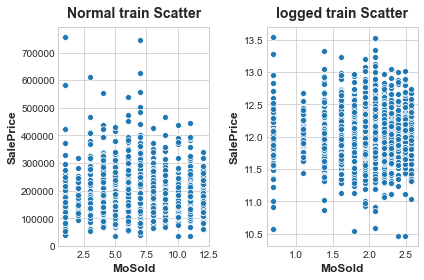

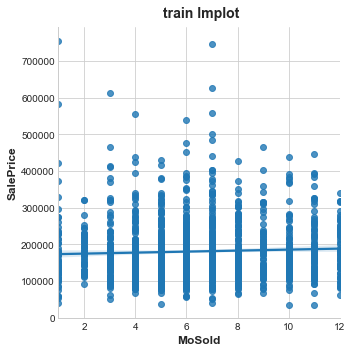

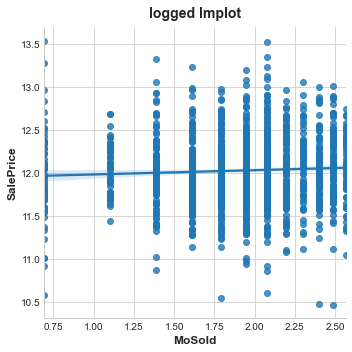



MSSubClass
Mi Score:  1.2818121163667624   || Corr Score:  -0.08428413512659526


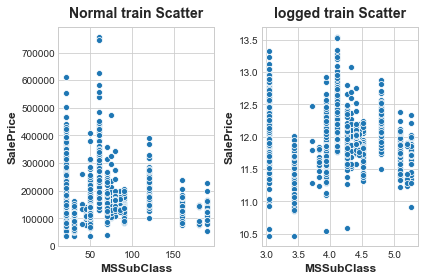

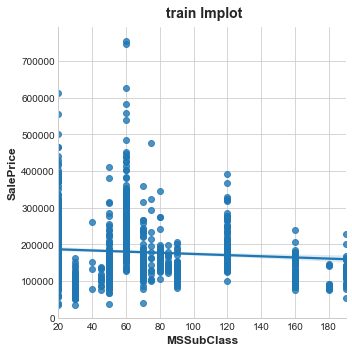

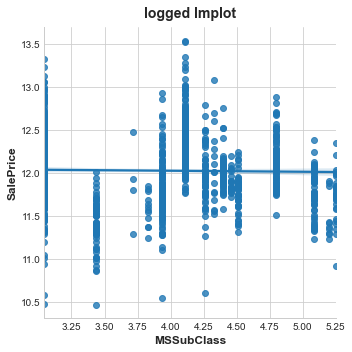



OverallQual
Mi Score:  1.1759891683036239   || Corr Score:  0.7909816005838048


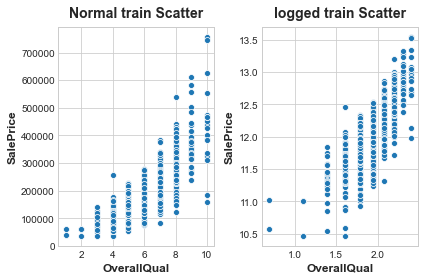

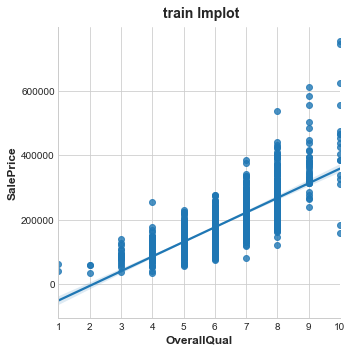

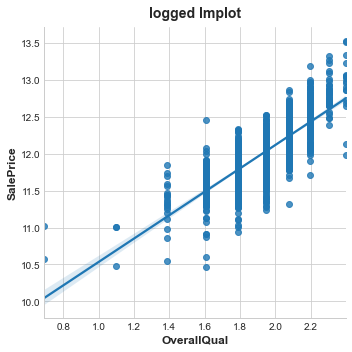



TotRmsAbvGrd
Mi Score:  1.1660998975588737   || Corr Score:  0.5337231555820284


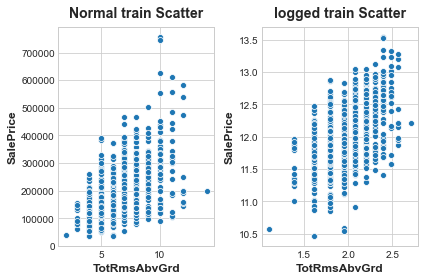

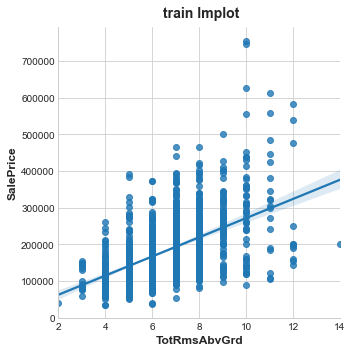

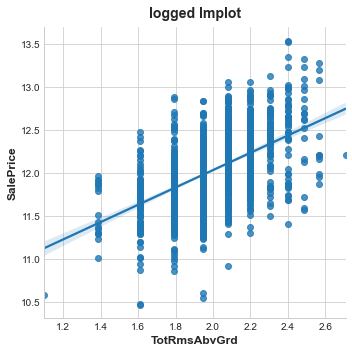



YrSold
Mi Score:  0.8470304475171968   || Corr Score:  -0.02892258516873034


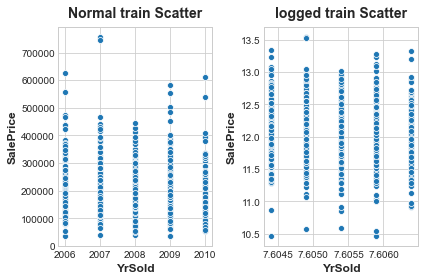

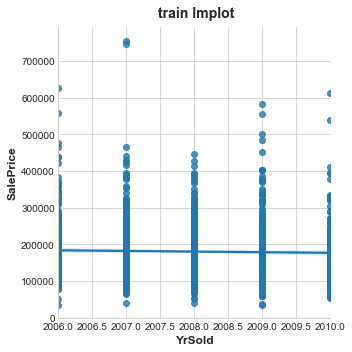

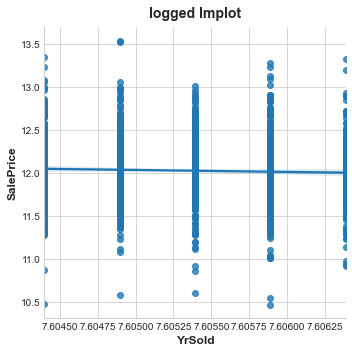



GarageCars
Mi Score:  0.7555623982260918   || Corr Score:  0.6404091972583531


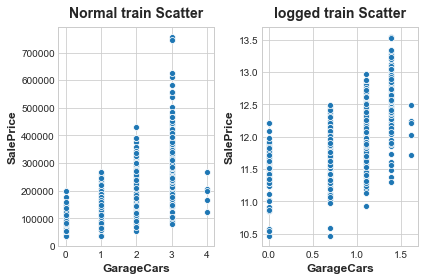

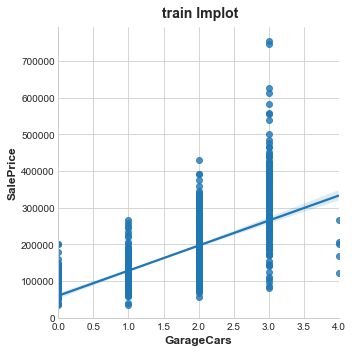

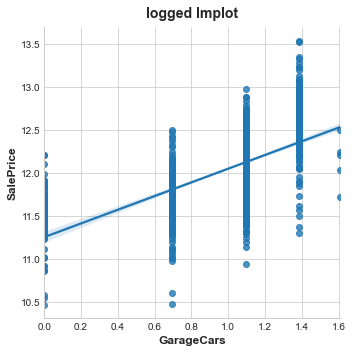



OverallCond
Mi Score:  0.7421824164050377   || Corr Score:  -0.077855894048678


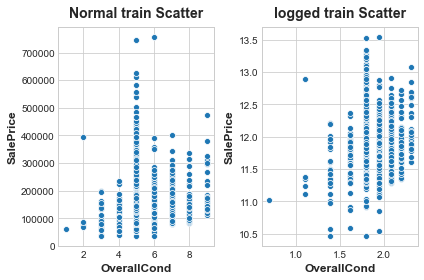

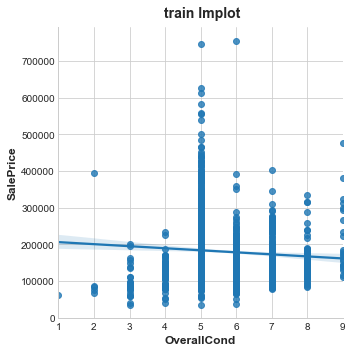

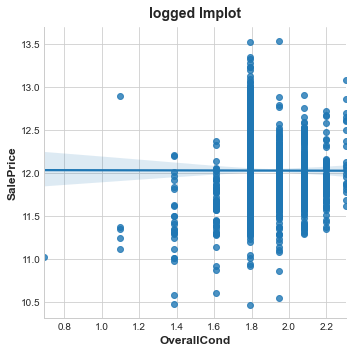



BedroomAbvGr
Mi Score:  0.6853554589659866   || Corr Score:  0.16821315430073996


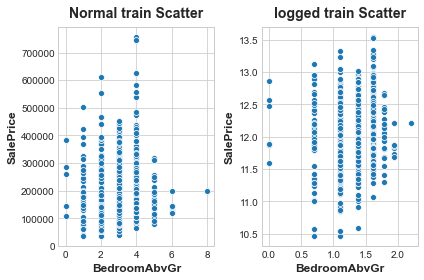

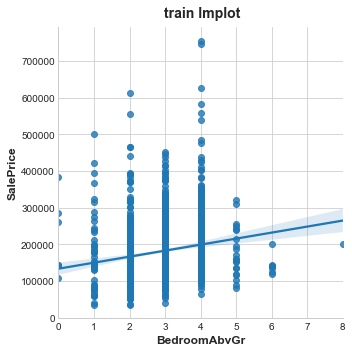

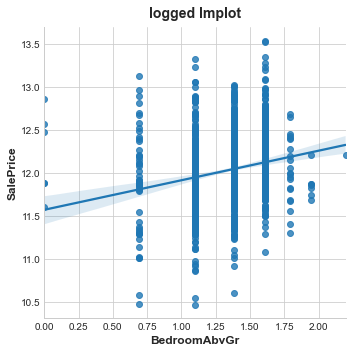



FullBath
Mi Score:  0.5499523994617983   || Corr Score:  0.5606637627484456


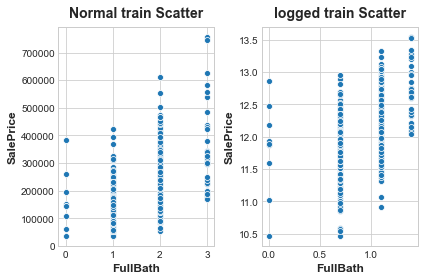

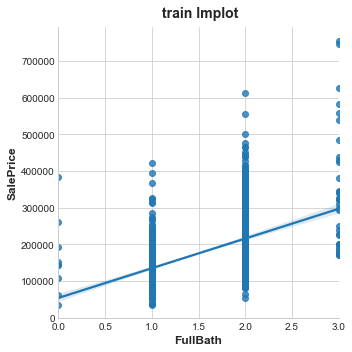

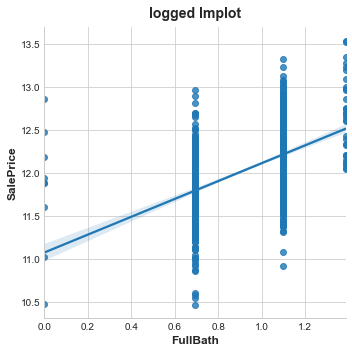



Fireplaces
Mi Score:  0.5437257069287   || Corr Score:  0.46692883675152763


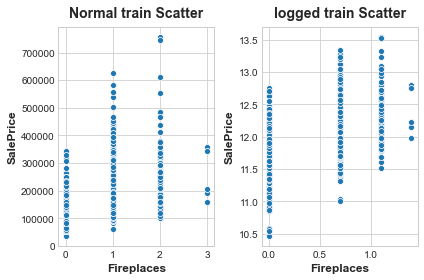

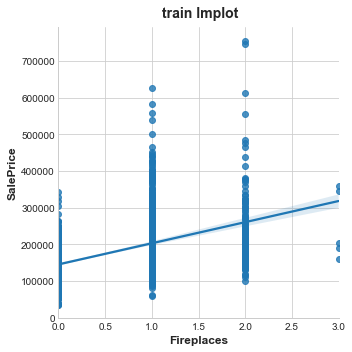

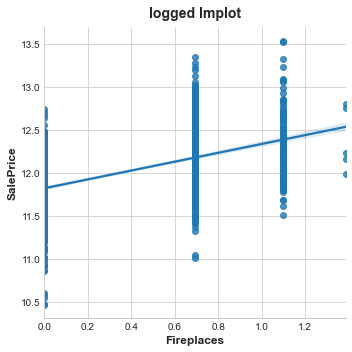



HalfBath
Mi Score:  0.3794213444601428   || Corr Score:  0.2841076755947829


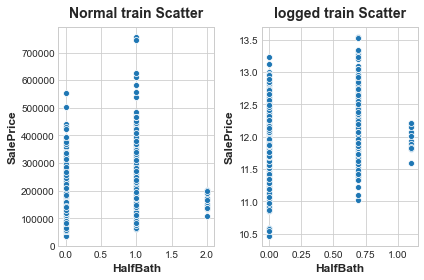

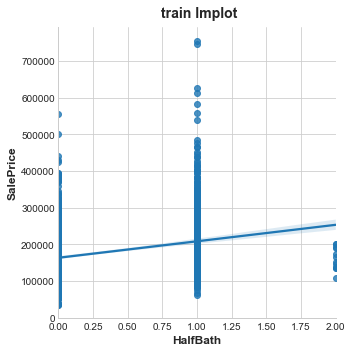

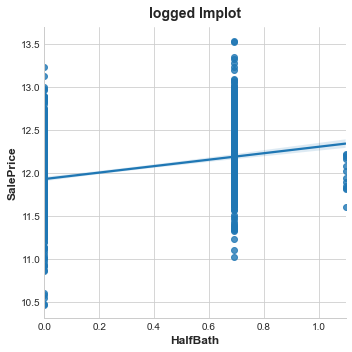



BsmtFullBath
Mi Score:  0.3548722888962236   || Corr Score:  0.22712223313149404


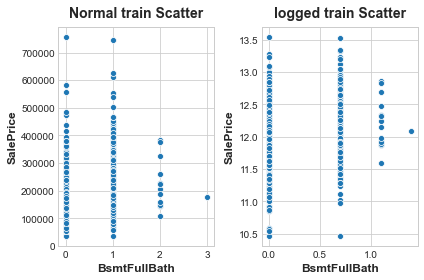

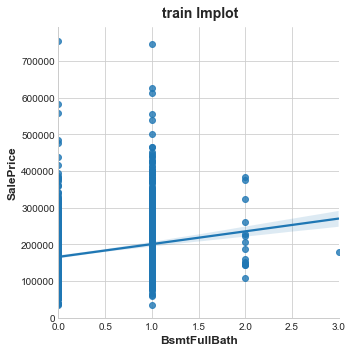

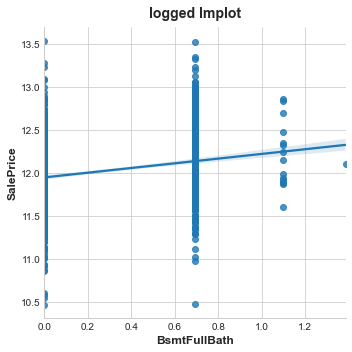



KitchenAbvGr
Mi Score:  0.11902761035276407   || Corr Score:  -0.1359073708421411


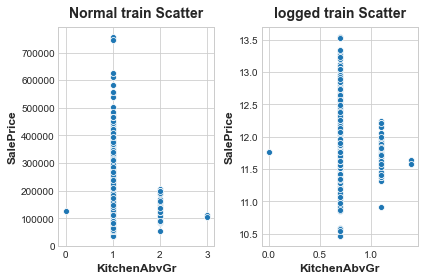

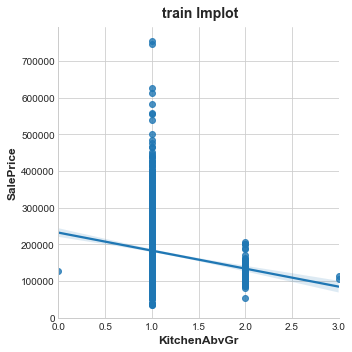

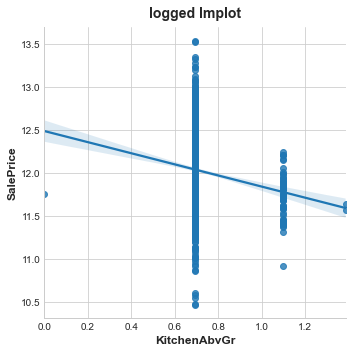

In [64]:
plot_mutual_info_and_corr(df=train,cols=num_cat,target_col='SalePrice',fill_na=-9.0)

## Continous Variable

In [23]:
continous = nums_train.drop(num_cat)

mi_score  Corr_Score
Id             6.132837   -0.021917
SalePrice      6.132837    1.000000
LotArea        5.576921    0.263843
GrLivArea      5.385650    0.708624
1stFlrSF       5.228554    0.605852
BsmtUnfSF      5.118456    0.214479
TotalBsmtSF    5.081468    0.613581
GarageArea     4.263250    0.623431
BsmtFinSF1     3.930450    0.386420
YearBuilt      3.253142    0.522897
GarageYrBlt    3.116733    0.260215
LotFrontage    2.773120    0.104201
YearRemodAdd   2.655247    0.507101
OpenPorchSF    2.634046    0.315856
2ndFlrSF       2.545305    0.319334
WoodDeckSF     2.407726    0.324413
MasVnrArea     2.371859    0.469327
EnclosedPorch  0.786388   -0.128578
BsmtFinSF2     0.689628   -0.011378
ScreenPorch    0.459365    0.111447
MiscVal        0.179636   -0.021190
BsmtHalfBath   0.123678   -0.016844
LowQualFinSF   0.113326   -0.025606
3SsnPorch      0.097585    0.044584
PoolArea       0.029648    0.092404

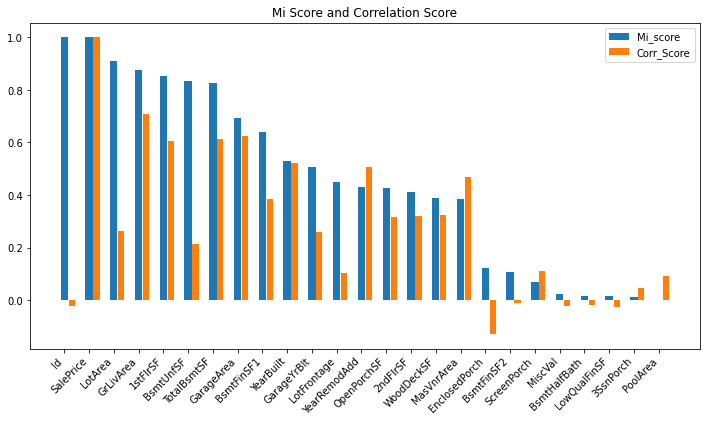

mi_score  Corr_Score
Id             6.132837   -0.021917
SalePrice      6.132837    1.000000
LotArea        5.576921    0.263843
GrLivArea      5.385650    0.708624
1stFlrSF       5.228554    0.605852
BsmtUnfSF      5.118456    0.214479
TotalBsmtSF    5.081468    0.613581
GarageArea     4.263250    0.623431
BsmtFinSF1     3.930450    0.386420
YearBuilt      3.253142    0.522897
GarageYrBlt    3.116733    0.260215
LotFrontage    2.773120    0.104201
YearRemodAdd   2.655247    0.507101
OpenPorchSF    2.634046    0.315856
2ndFlrSF       2.545305    0.319334
WoodDeckSF     2.407726    0.324413
MasVnrArea     2.371859    0.469327
EnclosedPorch  0.786388   -0.128578
BsmtFinSF2     0.689628   -0.011378
ScreenPorch    0.459365    0.111447
MiscVal        0.179636   -0.021190
BsmtHalfBath   0.123678   -0.016844
LowQualFinSF   0.113326   -0.025606
3SsnPorch      0.097585    0.044584
PoolArea       0.029648    0.092404

In [24]:
mi_score_and_corr_continous(df=train,cols=continous,target_col='SalePrice',fill_na=-99)

mi_score  Corr_Score
Id             6.132837   -0.021917
SalePrice      6.132837    1.000000
LotArea        5.576921    0.263843
GrLivArea      5.385650    0.708624
1stFlrSF       5.228554    0.605852
BsmtUnfSF      5.118456    0.214479
TotalBsmtSF    5.081468    0.613581
GarageArea     4.263250    0.623431
BsmtFinSF1     3.930450    0.386420
YearBuilt      3.253142    0.522897
GarageYrBlt    3.116733    0.260215
LotFrontage    2.773120    0.104201
YearRemodAdd   2.655247    0.507101
OpenPorchSF    2.634046    0.315856
2ndFlrSF       2.545305    0.319334
WoodDeckSF     2.407726    0.324413
MasVnrArea     2.371859    0.469327
EnclosedPorch  0.786388   -0.128578
BsmtFinSF2     0.689628   -0.011378
ScreenPorch    0.459365    0.111447
MiscVal        0.179636   -0.021190
BsmtHalfBath   0.123678   -0.016844
LowQualFinSF   0.113326   -0.025606
3SsnPorch      0.097585    0.044584
PoolArea       0.029648    0.092404

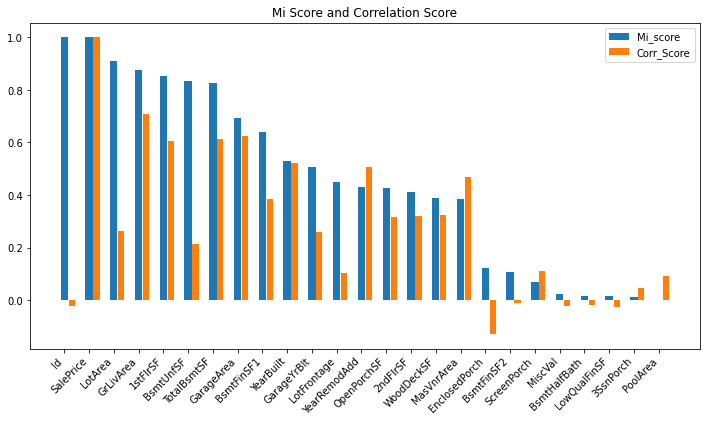

In [25]:
mi_score_num_continous = mi_score_and_corr_continous(df=train,cols=continous,target_col='SalePrice',fill_na=-99)

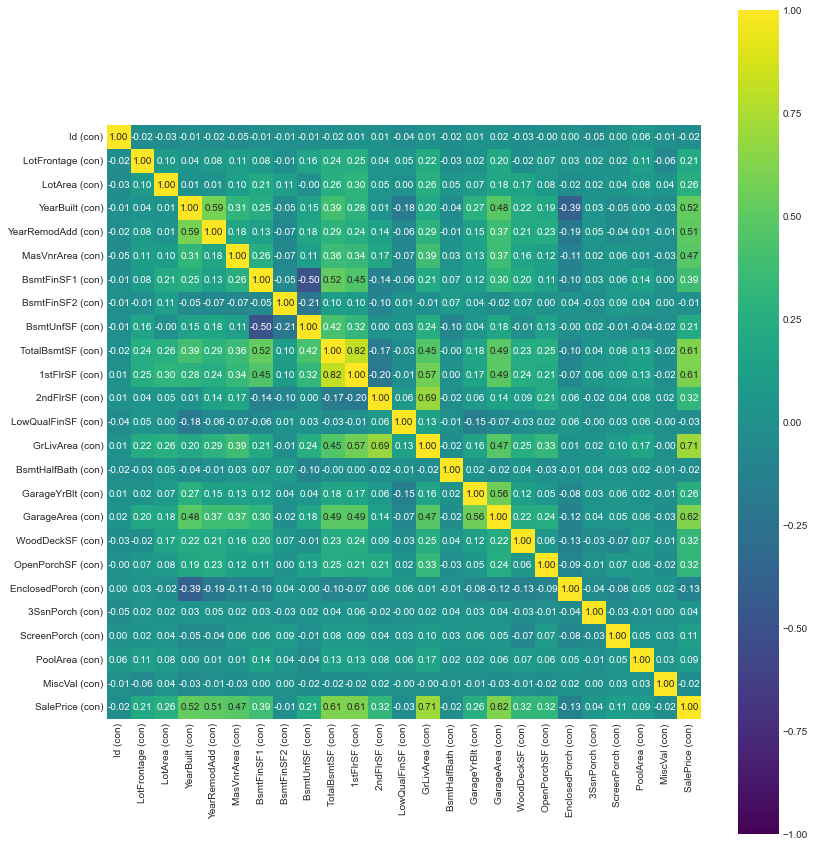

In [25]:
fig,ax = plt.subplots(figsize=(12,12))
associations(dataset=train[continous],numerical_columns='all',nan_replace_value=0,cmap='viridis',mark_columns=True,ax=ax)
fig.savefig("Num Cat kaggle house predictions.png")

### Base continous features
    We wanna select features with high correlation score and satisfory mi_score

In [26]:
thresh_corr = 0.3
mi_score_num_continous[mi_score_num_continous.Corr_Score>=thresh_corr]

mi_score  Corr_Score
SalePrice     6.132837    1.000000
GrLivArea     5.385650    0.708624
1stFlrSF      5.228554    0.605852
TotalBsmtSF   5.081468    0.613581
GarageArea    4.263250    0.623431
BsmtFinSF1    3.930450    0.386420
YearBuilt     3.253142    0.522897
YearRemodAdd  2.655247    0.507101
OpenPorchSF   2.634046    0.315856
2ndFlrSF      2.545305    0.319334
WoodDeckSF    2.407726    0.324413
MasVnrArea    2.371859    0.469327

In [27]:
mi_score_num_continous[mi_score_num_continous.Corr_Score>=thresh_corr].index

Index(['SalePrice', 'GrLivArea', '1stFlrSF', 'TotalBsmtSF', 'GarageArea',
       'BsmtFinSF1', 'YearBuilt', 'YearRemodAdd', 'OpenPorchSF', '2ndFlrSF',
       'WoodDeckSF', 'MasVnrArea'],
      dtype='object')

mi_score  Corr_Score
SalePrice     6.132837    1.000000
GrLivArea     5.385650    0.708624
1stFlrSF      5.228554    0.605852
TotalBsmtSF   5.081468    0.613581
GarageArea    4.263250    0.623431
BsmtFinSF1    3.930450    0.386420
YearBuilt     3.253142    0.522897
YearRemodAdd  2.655247    0.507101
OpenPorchSF   2.634046    0.315856
2ndFlrSF      2.545305    0.319334
WoodDeckSF    2.407726    0.324413
MasVnrArea    2.371859    0.472347

SalePrice
Mi Score:  6.132836979765857   || Corr Score:  0.9999999999999998


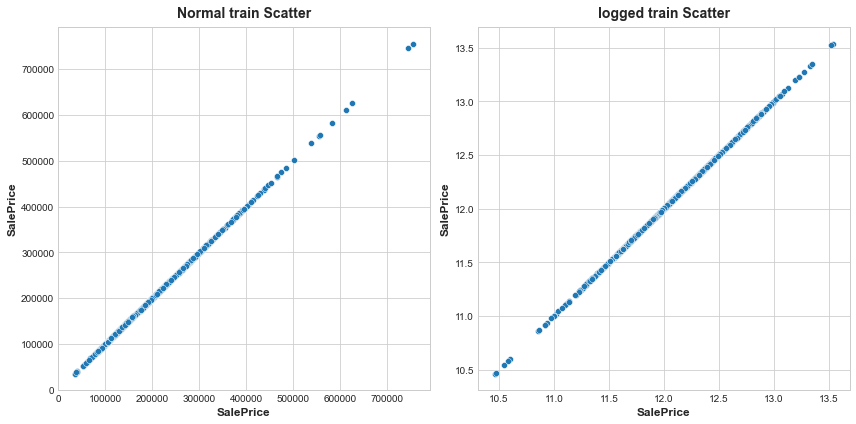

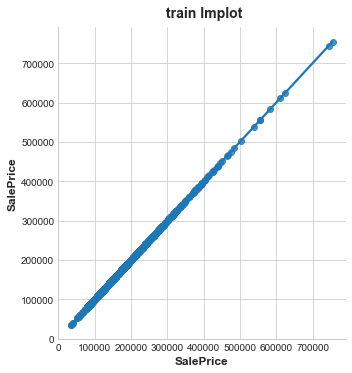

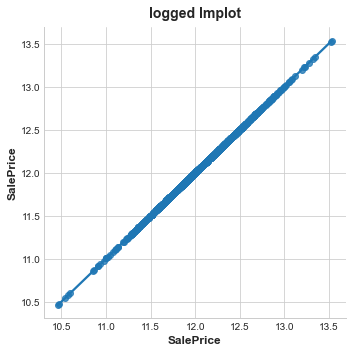



GrLivArea
Mi Score:  5.385649737431928   || Corr Score:  0.7086244776126521


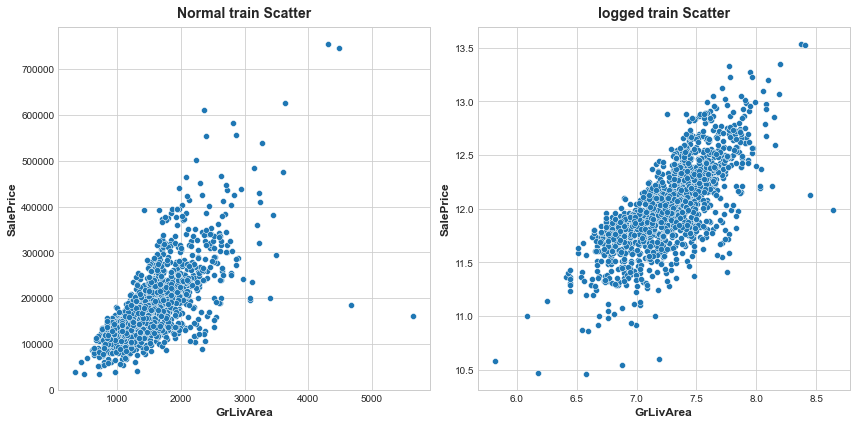

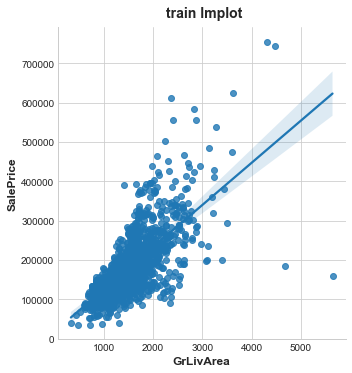

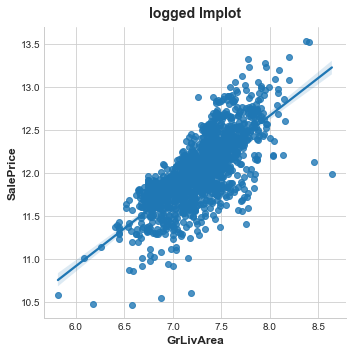



1stFlrSF
Mi Score:  5.228554426581789   || Corr Score:  0.6058521846919145


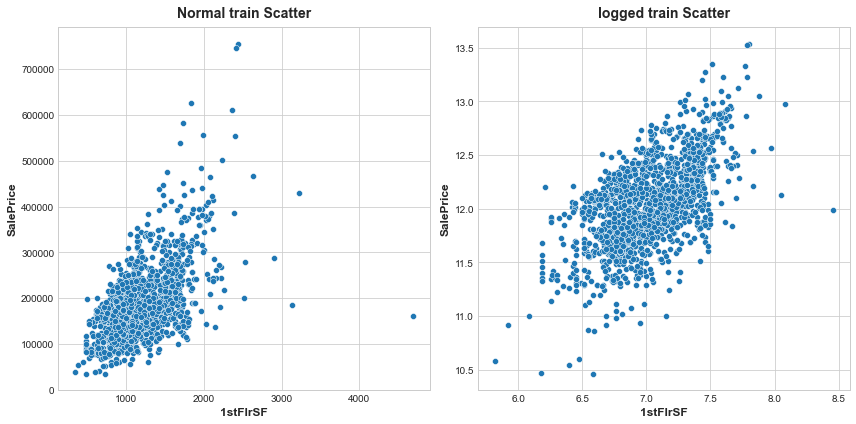

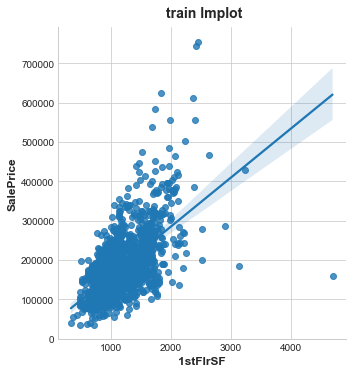

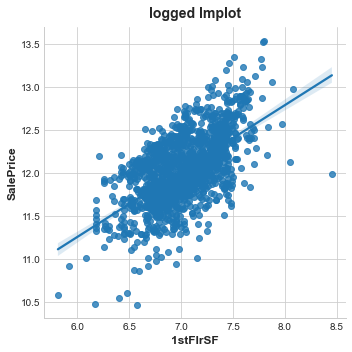



TotalBsmtSF
Mi Score:  5.081467656867101   || Corr Score:  0.6135805515591956


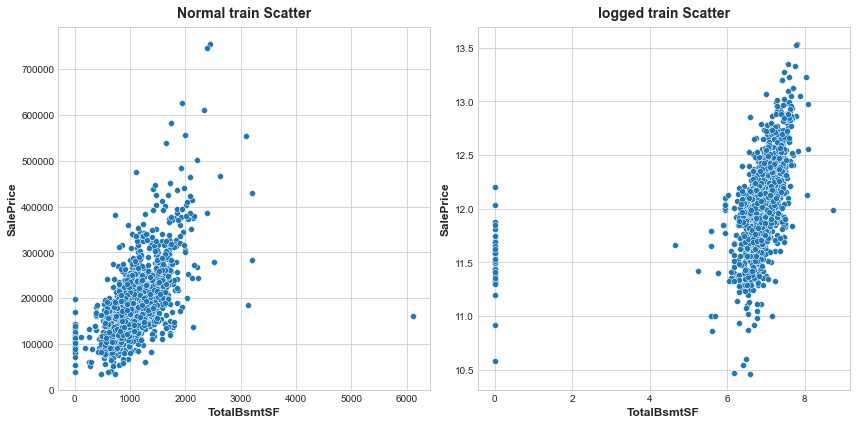

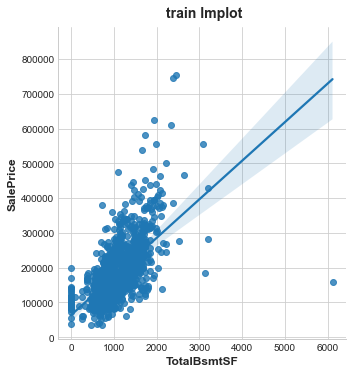

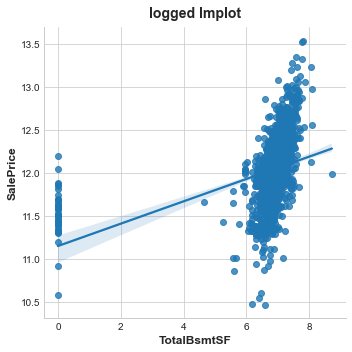



GarageArea
Mi Score:  4.2632500330554794   || Corr Score:  0.6234314389183617


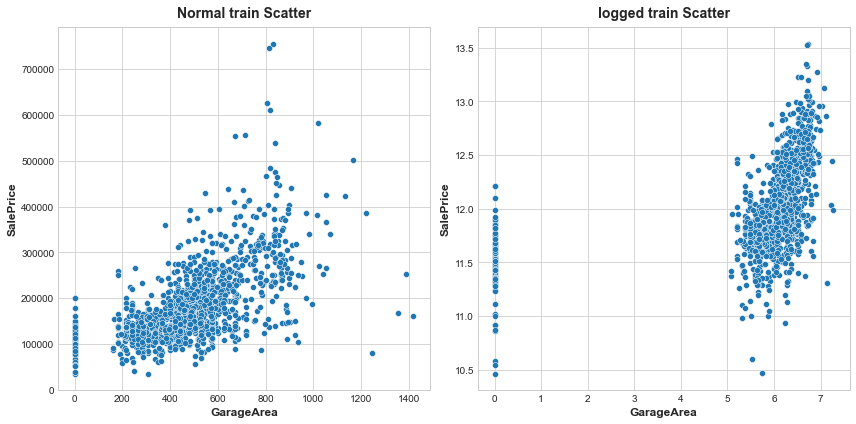

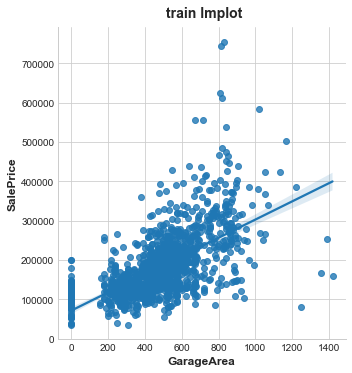

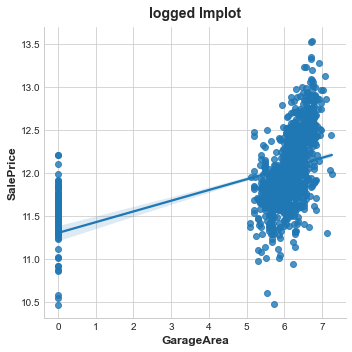



BsmtFinSF1
Mi Score:  3.9304503832320044   || Corr Score:  0.3864198062421531


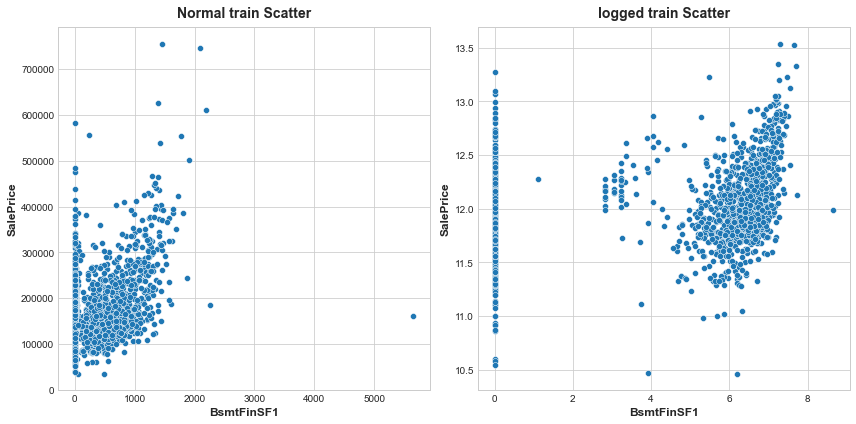

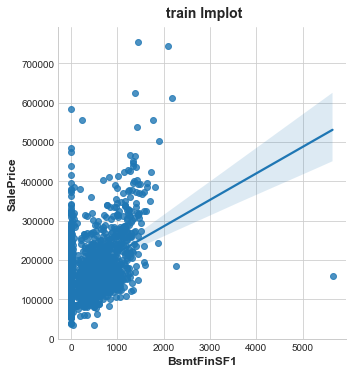

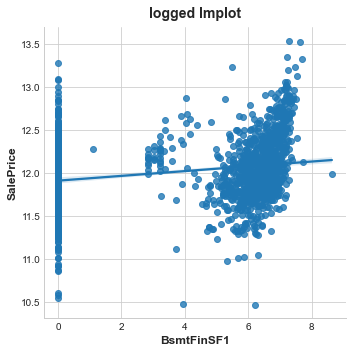



YearBuilt
Mi Score:  3.253142347725545   || Corr Score:  0.5228973328794968


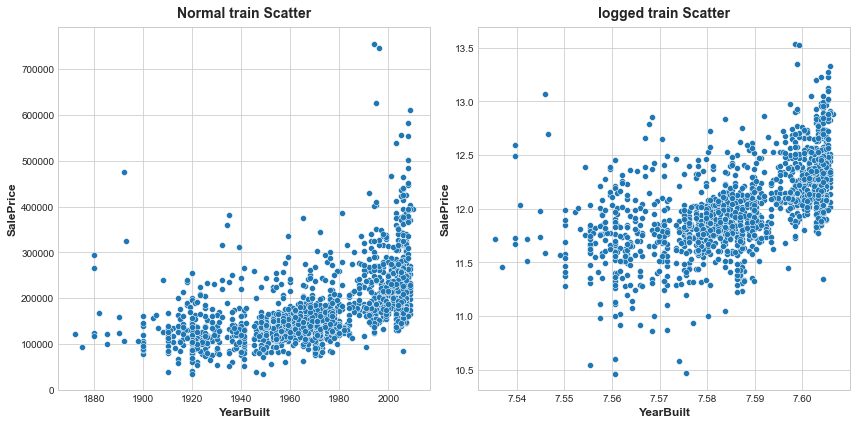

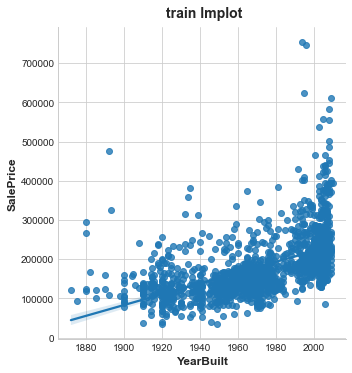

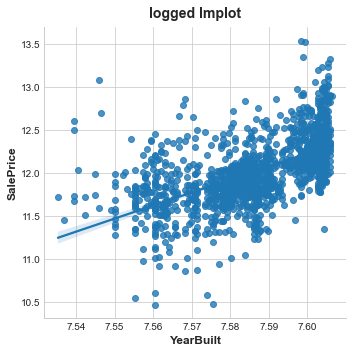



YearRemodAdd
Mi Score:  2.65524734606956   || Corr Score:  0.5071009671113862


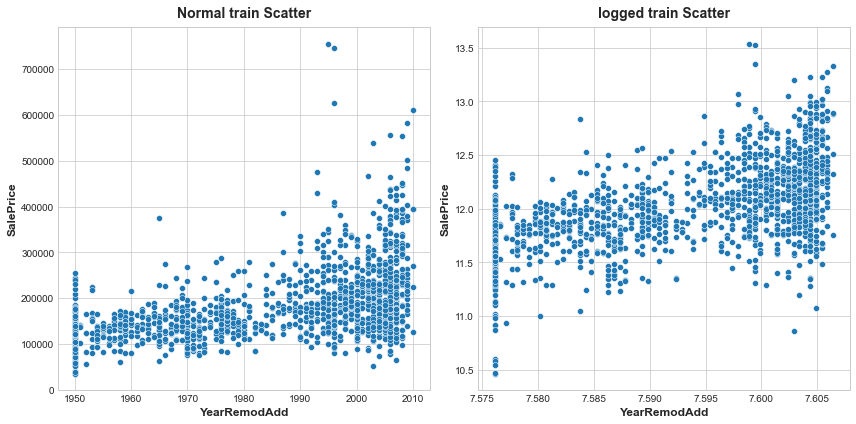

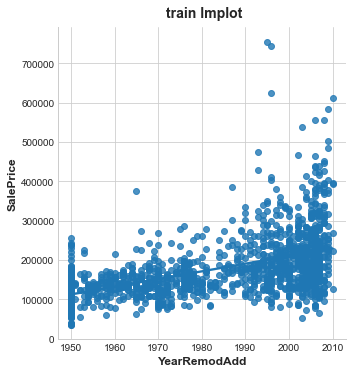

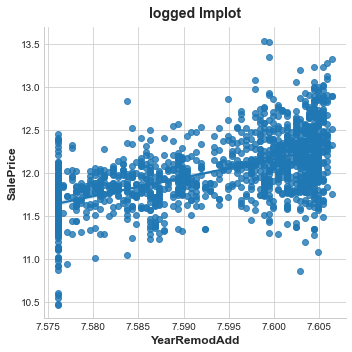



OpenPorchSF
Mi Score:  2.634046421219561   || Corr Score:  0.3158562271160552


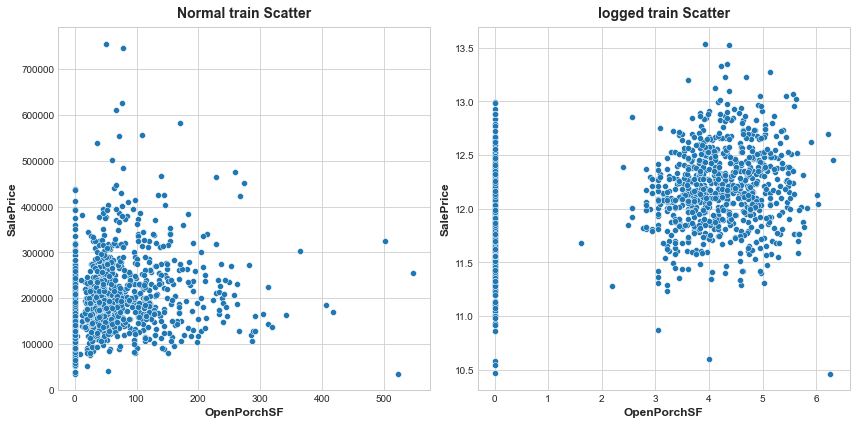

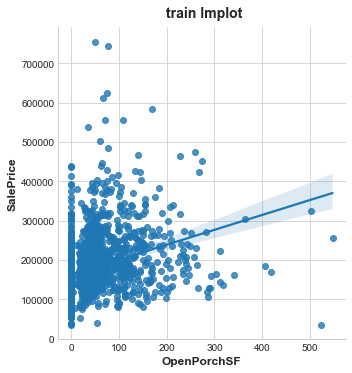

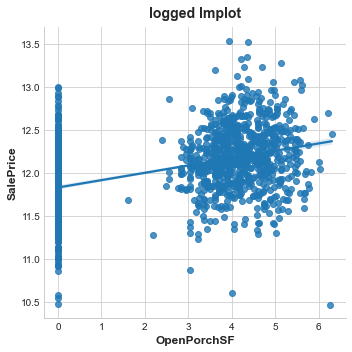



2ndFlrSF
Mi Score:  2.545305471074159   || Corr Score:  0.3193338028320677


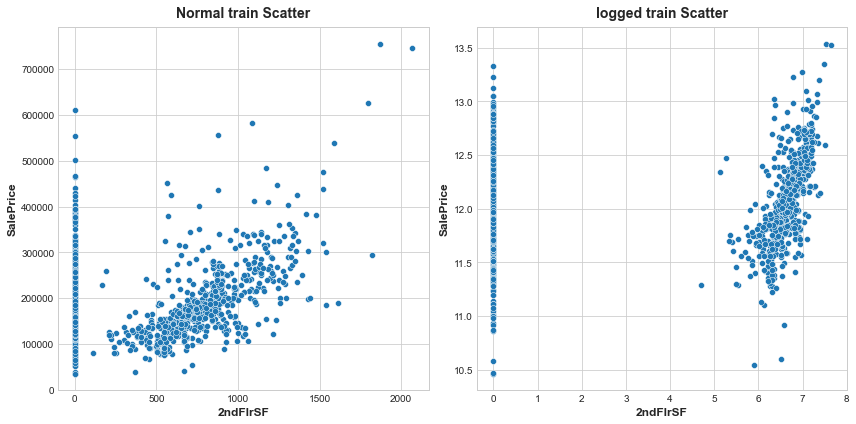

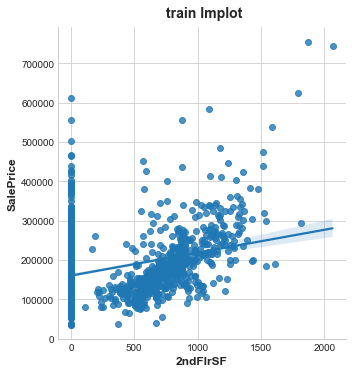

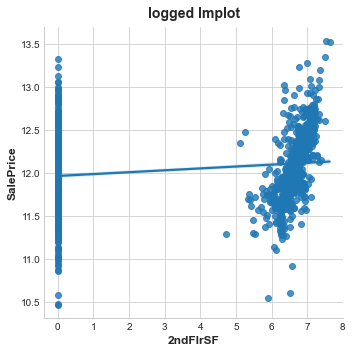



WoodDeckSF
Mi Score:  2.4077256971170415   || Corr Score:  0.3244134445681296


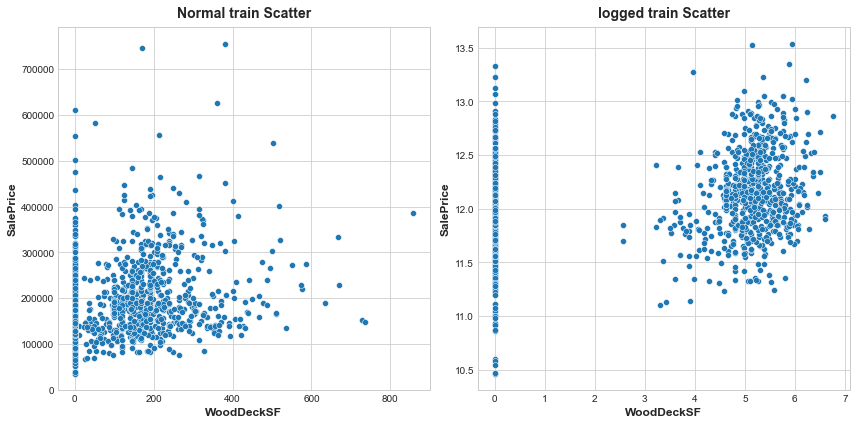

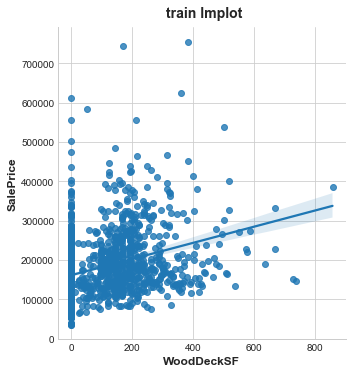

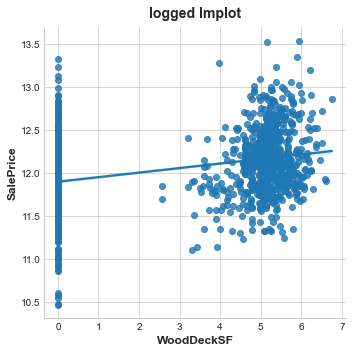



MasVnrArea
Mi Score:  2.371858584622926   || Corr Score:  0.4723467492527782


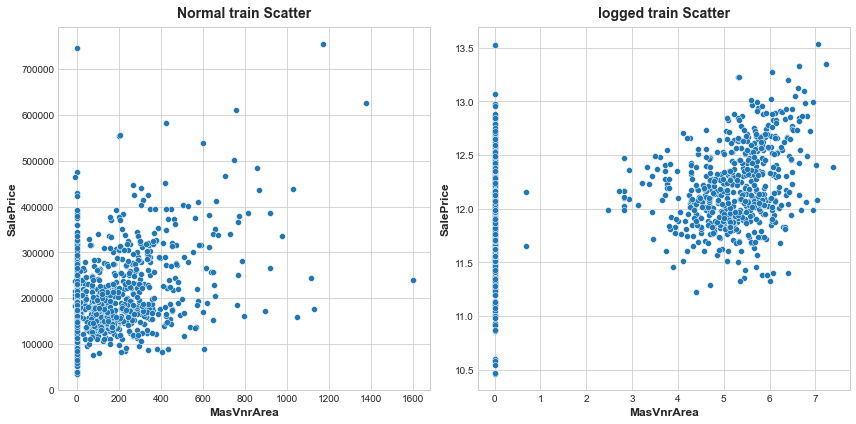

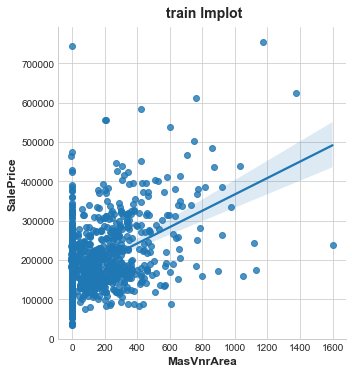

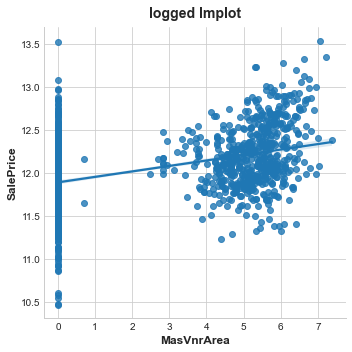

In [61]:
plot_mutual_info_and_corr(df=train,cols=mi_score_num_continous[mi_score_num_continous.Corr_Score>=thresh_corr].index,target_col='SalePrice',fill_na=-9.0)

In [29]:
#GrLivArea 4000,1stFlrSF 2500 ,TotalBsmtSF 3000 ,GarageArea 1200
condition = (train.GrLivArea <4000) & (train['1stFlrSF'] < 2500) & (train.TotalBsmtSF < 3000) & ( train.GarageArea  < 1200) & (train.MasVnrArea<1000)
no_outlier = train[condition]

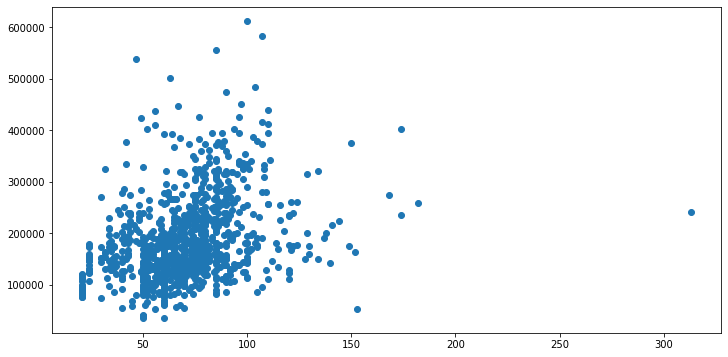

In [34]:
plt.scatter(no_outlier.LotFrontage, no_outlier.SalePrice)

In [36]:
no_outlier['LotFrontage'].corr(no_outlier.SalePrice)

0.3495322058947119

In [13]:
train.shape

(1460, 81)

In [32]:
train.OverallQual.value_counts()

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64

In [30]:
no_outlier.shape

(1432, 81)

In [33]:
no_outlier.OverallQual.value_counts()

5     396
6     371
7     313
8     162
4     115
9      43
3      19
10      8
2       3
1       2
Name: OverallQual, dtype: int64

mi_score  Corr_Score
SalePrice     6.107364    1.000000
GrLivArea     5.357844    0.711864
1stFlrSF      5.197532    0.615553
TotalBsmtSF   5.047586    0.633152
GarageArea    4.232784    0.652208
BsmtFinSF1    3.891085    0.376442
YearBuilt     3.251483    0.538327
YearRemodAdd  2.649458    0.528060
OpenPorchSF   2.610766    0.332172
2ndFlrSF      2.538674    0.305280
WoodDeckSF    2.397641    0.320260
MasVnrArea    2.313064    0.477597

SalePrice
Mi Score:  6.1073635480007304   || Corr Score:  1.0


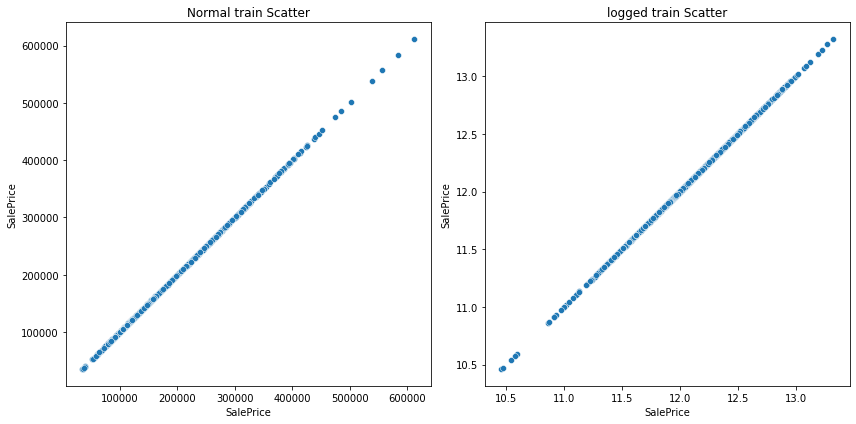

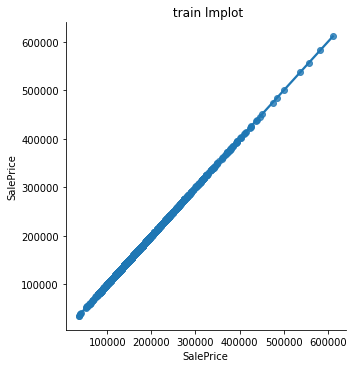

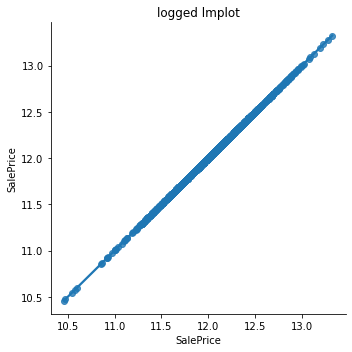



GrLivArea
Mi Score:  5.357843622731773   || Corr Score:  0.7118638665542872


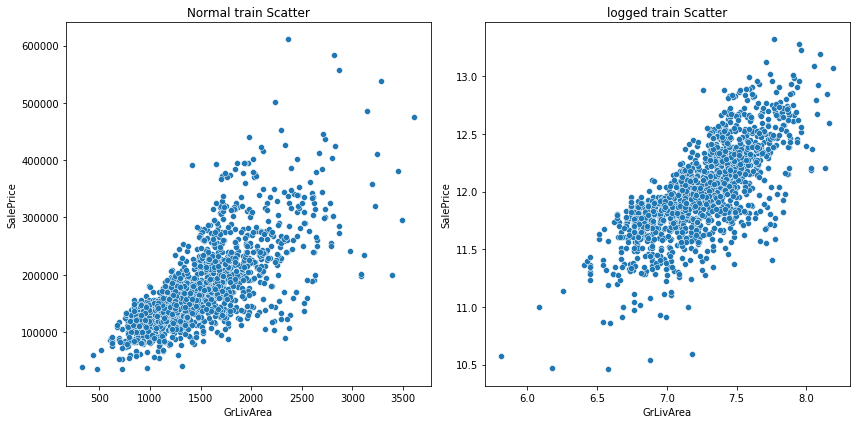

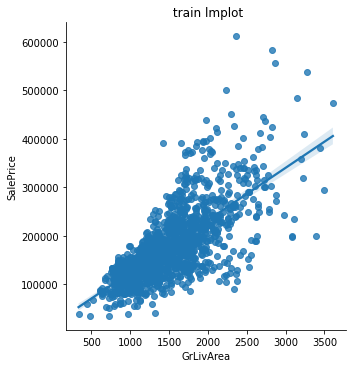

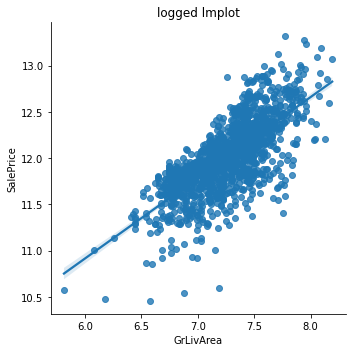



1stFlrSF
Mi Score:  5.197532311428228   || Corr Score:  0.6155526731427001


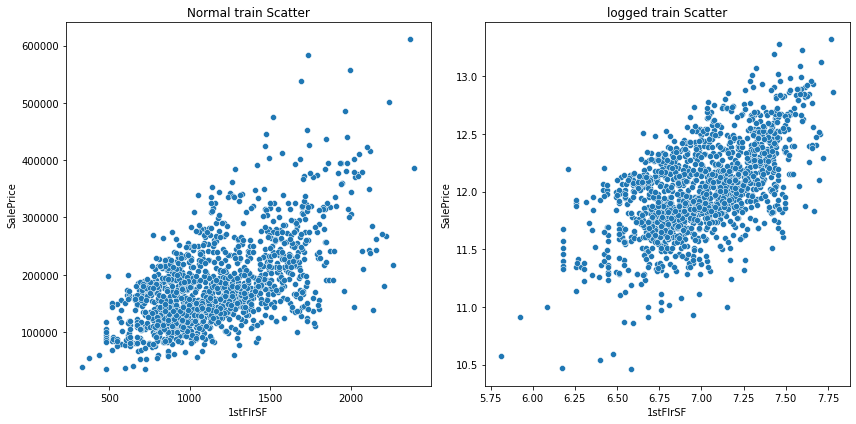

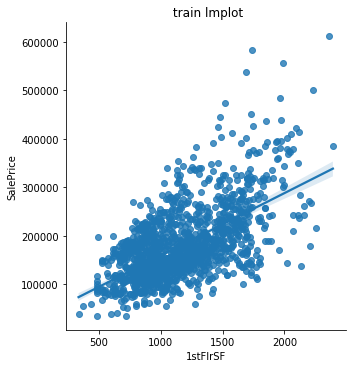

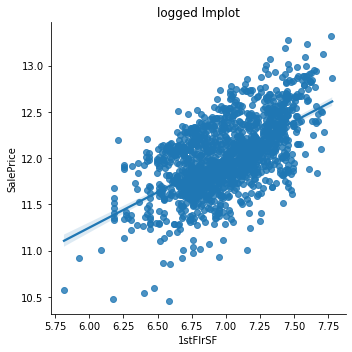



TotalBsmtSF
Mi Score:  5.047585740263322   || Corr Score:  0.6331524245059351


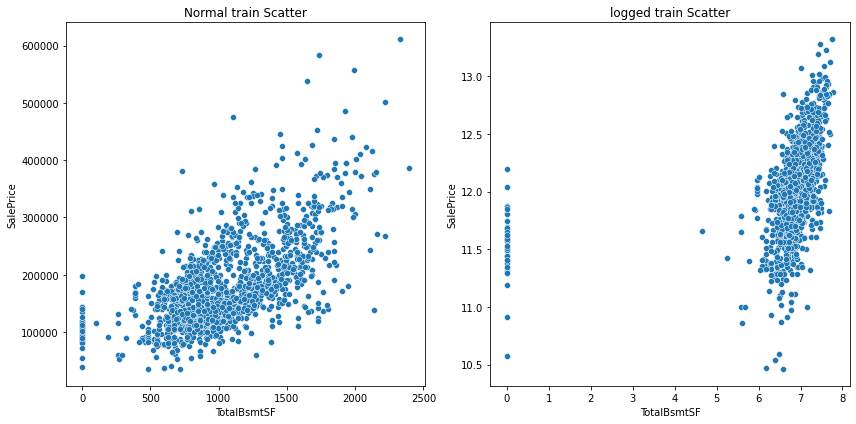

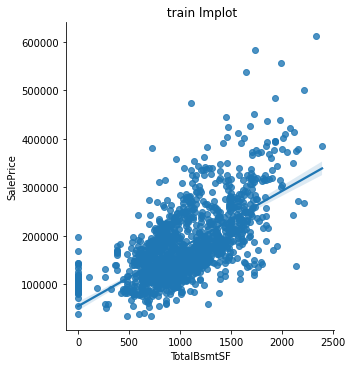

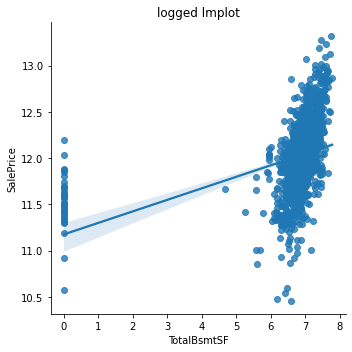



GarageArea
Mi Score:  4.232783977208263   || Corr Score:  0.6522079943265794


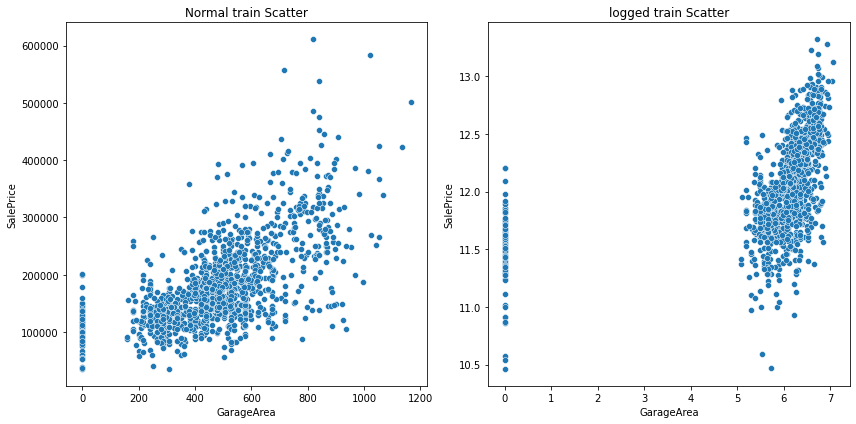

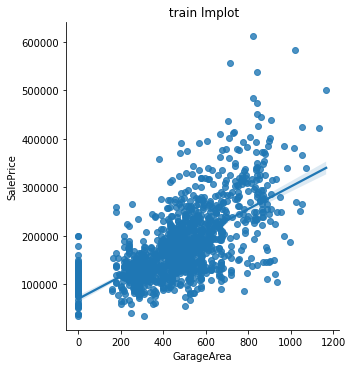

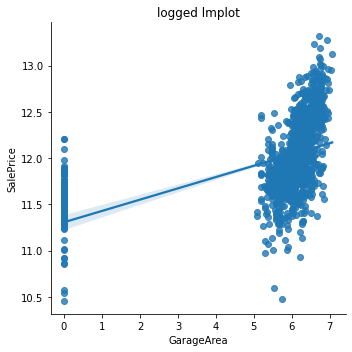



BsmtFinSF1
Mi Score:  3.8910847618976803   || Corr Score:  0.37644190022625335


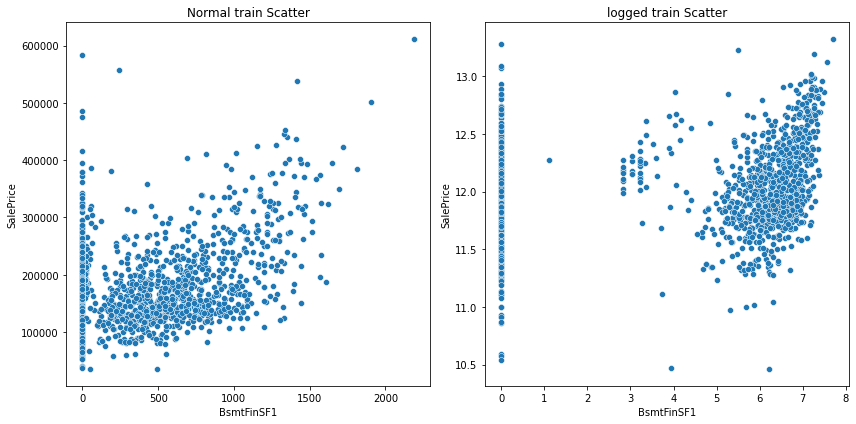

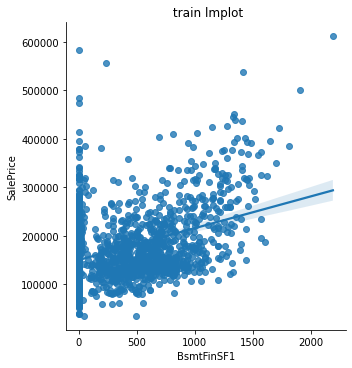

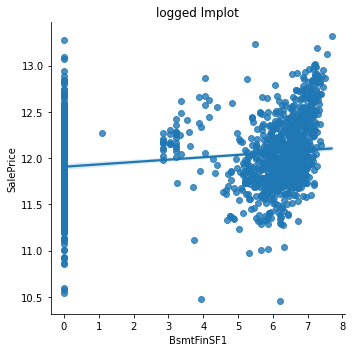



YearBuilt
Mi Score:  3.2514829901578968   || Corr Score:  0.5383274201322176


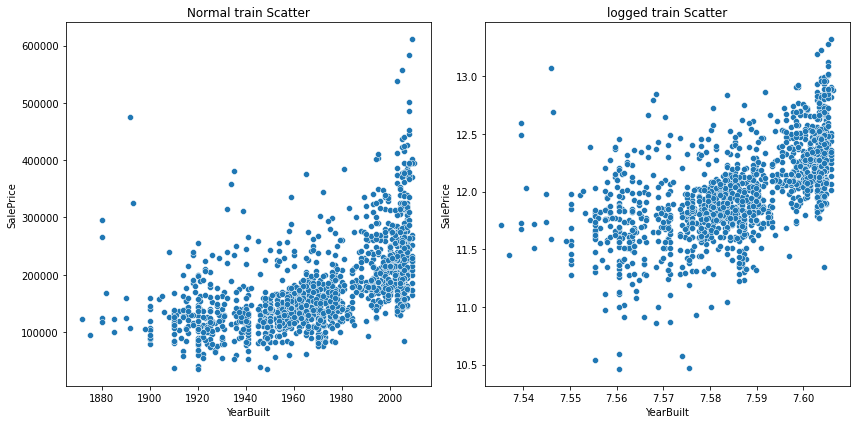

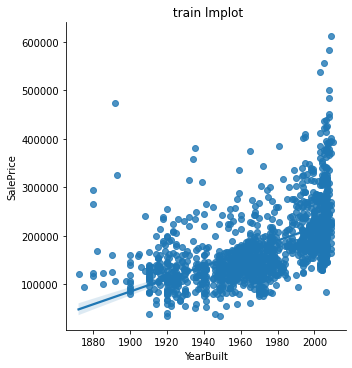

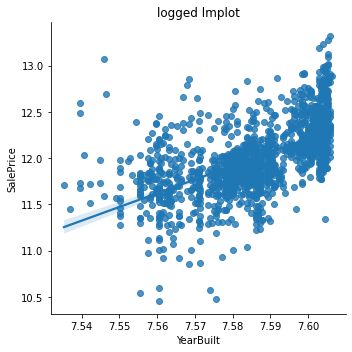



YearRemodAdd
Mi Score:  2.649457823211291   || Corr Score:  0.5280603698609531


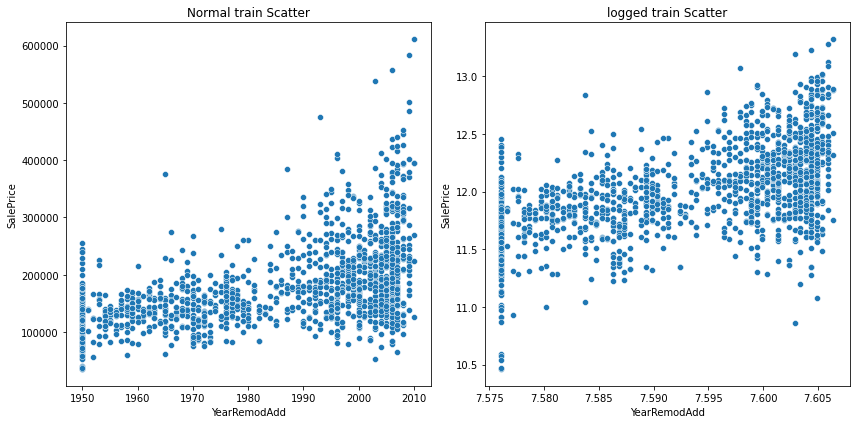

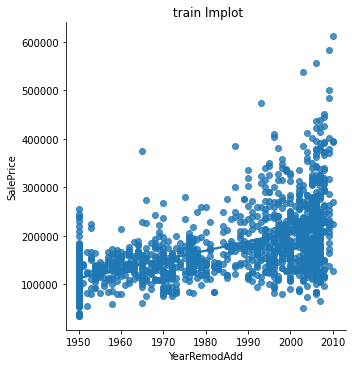

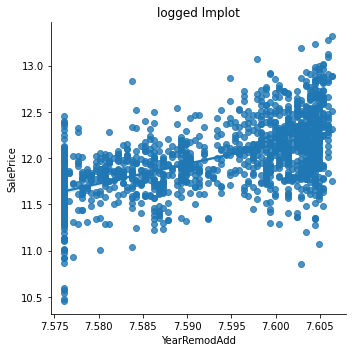



OpenPorchSF
Mi Score:  2.610766426872069   || Corr Score:  0.3321723092959252


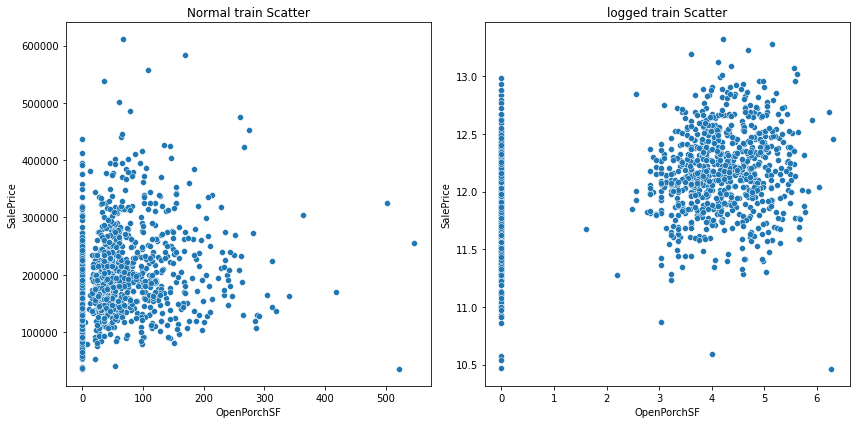

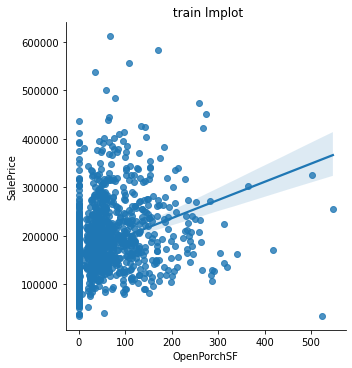

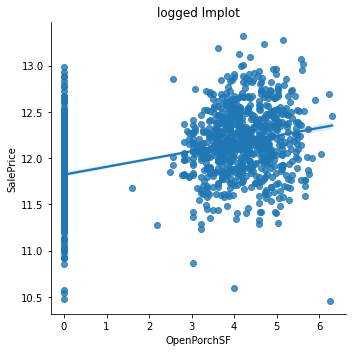



2ndFlrSF
Mi Score:  2.5386740192063195   || Corr Score:  0.3052801221895516


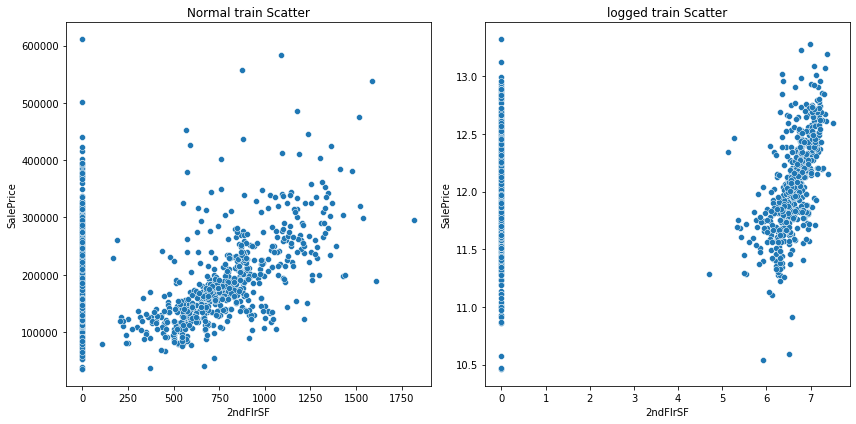

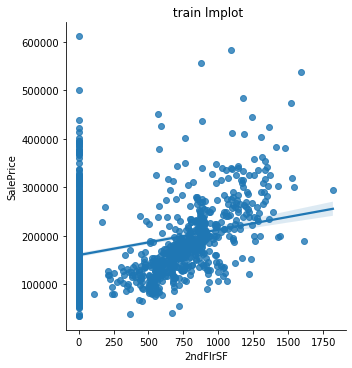

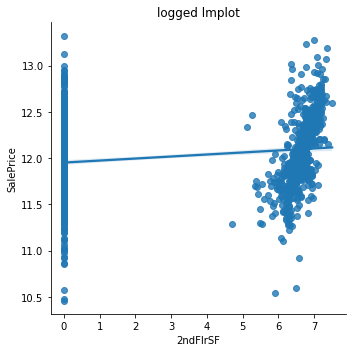



WoodDeckSF
Mi Score:  2.3976414020338748   || Corr Score:  0.32025953794770595


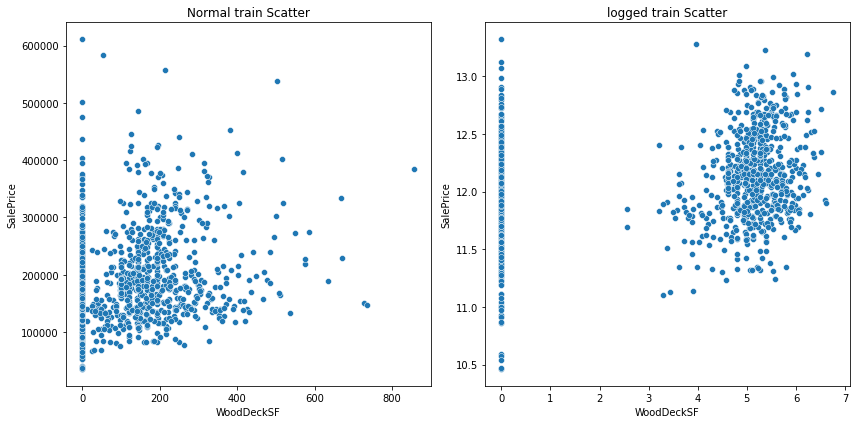

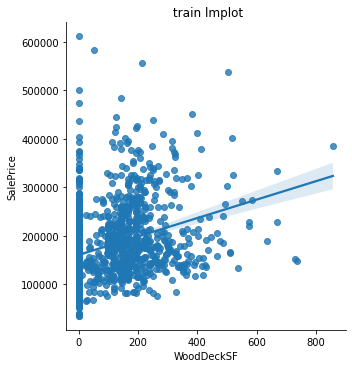

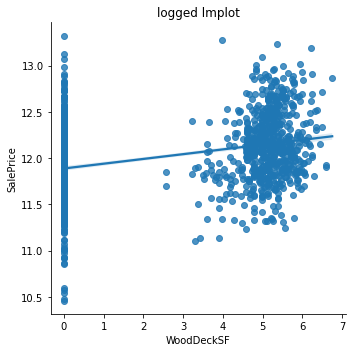



MasVnrArea
Mi Score:  2.3130640514009673   || Corr Score:  0.4775974175121963


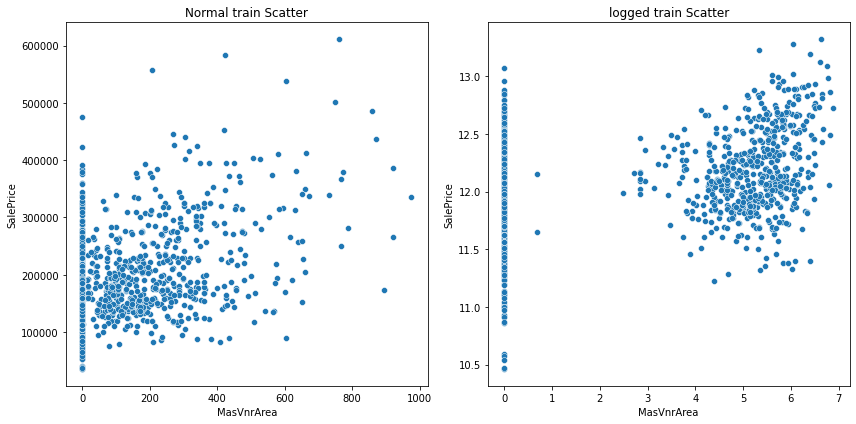

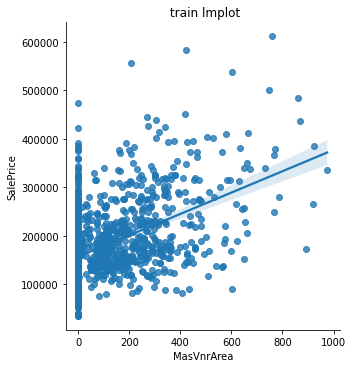

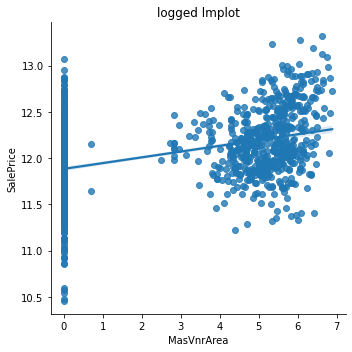

In [31]:

plot_mutual_info_and_corr(df=no_outlier,cols=mi_score_num_continous[mi_score_num_continous.Corr_Score>=thresh_corr].index,target_col='SalePrice',fill_na=0)

In [61]:
mi_score_and_corr(df=train,cols=nums_train,target_col='SalePrice',fill_na=-99)

mi_score  Corr_Score
SalePrice      6.132837    1.000000
Id             6.132837   -0.021917
LotArea        5.576921    0.263843
GrLivArea      5.385650    0.708624
1stFlrSF       5.228554    0.605852
BsmtUnfSF      5.118456    0.214479
TotalBsmtSF    5.081468    0.613581
GarageArea     4.263250    0.623431
BsmtFinSF1     3.930450    0.386420
YearBuilt      3.253142    0.522897
GarageYrBlt    3.116733    0.260215
LotFrontage    2.773120    0.104201
YearRemodAdd   2.655247    0.507101
OpenPorchSF    2.634046    0.315856
2ndFlrSF       2.545305    0.319334
WoodDeckSF     2.407726    0.324413
MasVnrArea     2.371859    0.469327
MoSold         1.422846    0.046432
MSSubClass     1.281812   -0.084284
OverallQual    1.175989    0.790982
TotRmsAbvGrd   1.166100    0.533723
YrSold         0.847030   -0.028923
EnclosedPorch  0.786388   -0.128578
GarageCars     0.755562    0.640409
OverallCond    0.742182   -0.077856
BsmtFinSF2     0.689628   -0.011378
BedroomAbvGr   0.685355    0.168213
FullBath       0.549952    0.560664
Fireplaces     0.543726    0.466929
ScreenPorch    0.459365    0.111447
HalfBath       0.379421    0.284108
BsmtFullBath   0.354872    0.227122
MiscVal        0.179636   -0.021190
BsmtHalfBath   0.123678   -0.016844
KitchenAbvGr   0.119028   -0.135907
LowQualFinSF   0.113326   -0.025606
3SsnPorch      0.097585    0.044584
PoolArea       0.029648    0.092404

#### so what does this tells us??
##### Mutual_Info:
    * scores the features that helps in predicting the target column

##### Corr_Score
    Range |  Relationship_Strengh | Inference

* 0.0 to -0.2 or 0.0 to 0.2 = LOW = RARELY
* -0.2 to -0.5 or 0.2 to 0.5 = MODERATE = SOMETIMES
* -0.6 to -1.0 or 0.6 to 1.0 = STRONG = OFTEN

In [35]:
def mi_score_cat(df,cols,target_col,fill_na):
    df_def = df.copy()
    df_def = df_def.fillna(fill_na)
    
    def mutual_info_price_score(series):
        return mutual_info_score(series,df_def[target_col])
    
    mi_normal = df_def[cols].apply(mutual_info_price_score)
    features = mi_normal.sort_values(ascending=False).index.to_list()
    scores = mi_normal.sort_values(ascending=False).values
    
    corr_cat = associations(dataset=df_def[(cols.to_list() +[target_col])],numerical_columns=target_col,nan_replace_value=fill_na,cmap='viridis',mark_columns=False,ax=None,compute_only=True)
    #corr_num_cat['corr']['SalePrice']['MSSubClass']
    #correlation = df_def[cols].corrwith(df_def[target_col])
    mi_corr_df = pd.DataFrame(scores,index=features,columns=['mi_score'])
    mi_corr_df['Corr_Score']= [corr_cat['corr'][target_col][col]  for col in features ]
    

    display(mi_corr_df)
    
    print()
    plt.rc("figure",figsize=(12,6))
    X_axis = np.arange(0,mi_corr_df.shape[0])
    max_mi_score = mi_corr_df['mi_score'].max() # since correlation is always <=1 ..for better visualization we normalize
    min_mi_score = mi_corr_df['mi_score'].min()
    norm_mi_score = (mi_corr_df['mi_score'] - min_mi_score)/(max_mi_score-min_mi_score)
    plt.bar(X_axis,norm_mi_score,label='Mi_score',width=0.3)
    plt.bar(X_axis + 0.3,mi_corr_df['Corr_Score'],label='Corr_Score',width=0.25)
    ticks = X_axis # points on the x axis where you want the label to appear
    labels=mi_corr_df.index
    plt.xticks(ticks, labels);
    ax = plt.gca()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.title("Mi Score and Correlation Score")
    plt.legend()
    plt.show()
    
    return mi_corr_df
    

mi_score  Corr_Score
Neighborhood   2.003888    0.738630
Exterior2nd    1.172542    0.392211
Exterior1st    1.116941    0.390862
BsmtFinType1   0.961786    0.459141
FireplaceQu    0.752668    0.542181
GarageFinish   0.752268    0.553059
BsmtQual       0.747080    0.681905
HouseStyle     0.721220    0.293790
KitchenQual    0.676428    0.675721
GarageType     0.673624    0.499204
BsmtExposure   0.666649    0.386653
Foundation     0.637097    0.506328
HeatingQC      0.603568    0.442154
ExterQual      0.602146    0.690933
MasVnrType     0.558353    0.434537
LotConfig      0.472501    0.144981
SaleCondition  0.466175    0.368100
LotShape       0.446402    0.276362
MSZoning       0.423127    0.327963
SaleType       0.403521    0.370523
BsmtFinType2   0.399378    0.174052
Condition1     0.380689    0.180640
BldgType       0.379890    0.185833
Fence          0.375979    0.188719
RoofStyle      0.358190    0.240201
BsmtCond       0.298651    0.226706
GarageQual     0.288712    0.285344
LandContour    0.277517    0.160605
GarageCond     0.260239    0.285213
ExterCond      0.237318    0.153680
Electrical     0.220085    0.244318
Functional     0.217802    0.128376
PavedDrive     0.197437    0.233537
Alley          0.166222    0.142855
CentralAir     0.157975    0.251328
LandSlope      0.149264    0.051784
MiscFeature    0.107683    0.084141
Heating        0.095034    0.120155
RoofMatl       0.082170    0.177237
Condition2     0.055250    0.099495
PoolQC         0.025492    0.145588
Street         0.021418    0.041036
Utilities      0.003824    0.014314

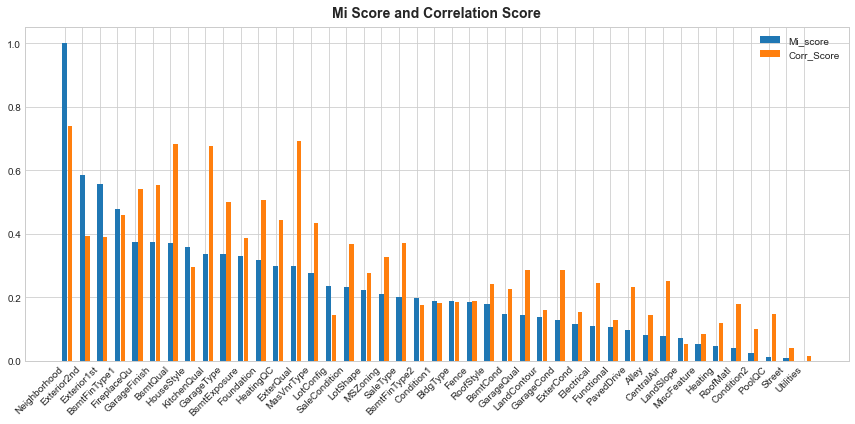

In [55]:
mi_score_categorical = mi_score_cat(df=train,cols=cats_train,target_col='SalePrice',fill_na='missing')

#### using clustering

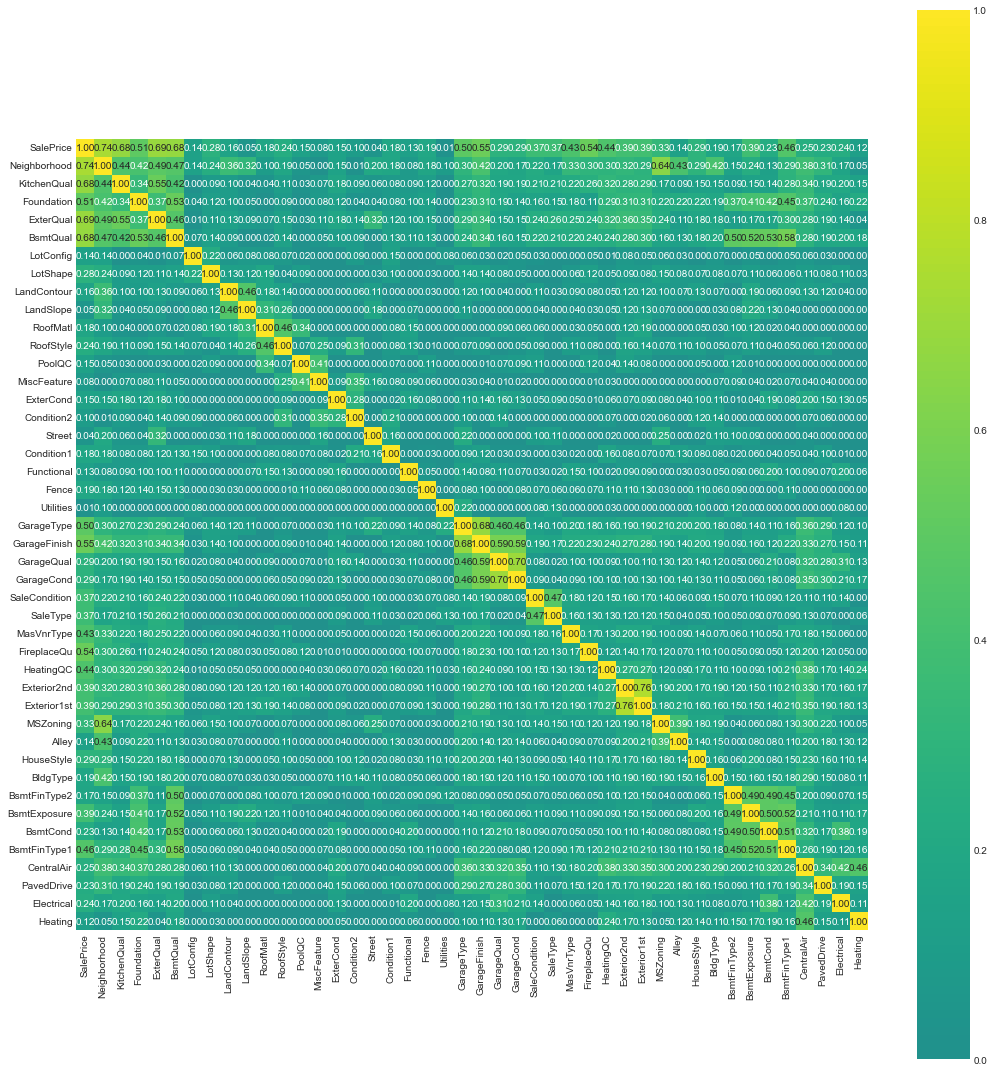

In [38]:
fig,ax = plt.subplots(figsize=(15,15))
associations(dataset=train[(cats_train.to_list() +['SalePrice'])],numerical_columns='SalePrice',nan_replace_value='missing',cmap='viridis',mark_columns=False,ax=ax,clustering=True)
fig.savefig("Categorical Features kaggle house predictions using clustering.png")

### Base categorical features
    We wanna select features with high correlation score and satisfory mi_score

In [56]:
thresh_corr = 0.3
mi_score_categorical[mi_score_categorical.Corr_Score>=thresh_corr]

mi_score  Corr_Score
Neighborhood   2.003888    0.738630
Exterior2nd    1.172542    0.392211
Exterior1st    1.116941    0.390862
BsmtFinType1   0.961786    0.459141
FireplaceQu    0.752668    0.542181
GarageFinish   0.752268    0.553059
BsmtQual       0.747080    0.681905
KitchenQual    0.676428    0.675721
GarageType     0.673624    0.499204
BsmtExposure   0.666649    0.386653
Foundation     0.637097    0.506328
HeatingQC      0.603568    0.442154
ExterQual      0.602146    0.690933
MasVnrType     0.558353    0.434537
SaleCondition  0.466175    0.368100
MSZoning       0.423127    0.327963
SaleType       0.403521    0.370523

In [57]:
mi_score_categorical[mi_score_categorical.Corr_Score>=thresh_corr].index

Index(['Neighborhood', 'Exterior2nd', 'Exterior1st', 'BsmtFinType1',
       'FireplaceQu', 'GarageFinish', 'BsmtQual', 'KitchenQual', 'GarageType',
       'BsmtExposure', 'Foundation', 'HeatingQC', 'ExterQual', 'MasVnrType',
       'SaleCondition', 'MSZoning', 'SaleType'],
      dtype='object')

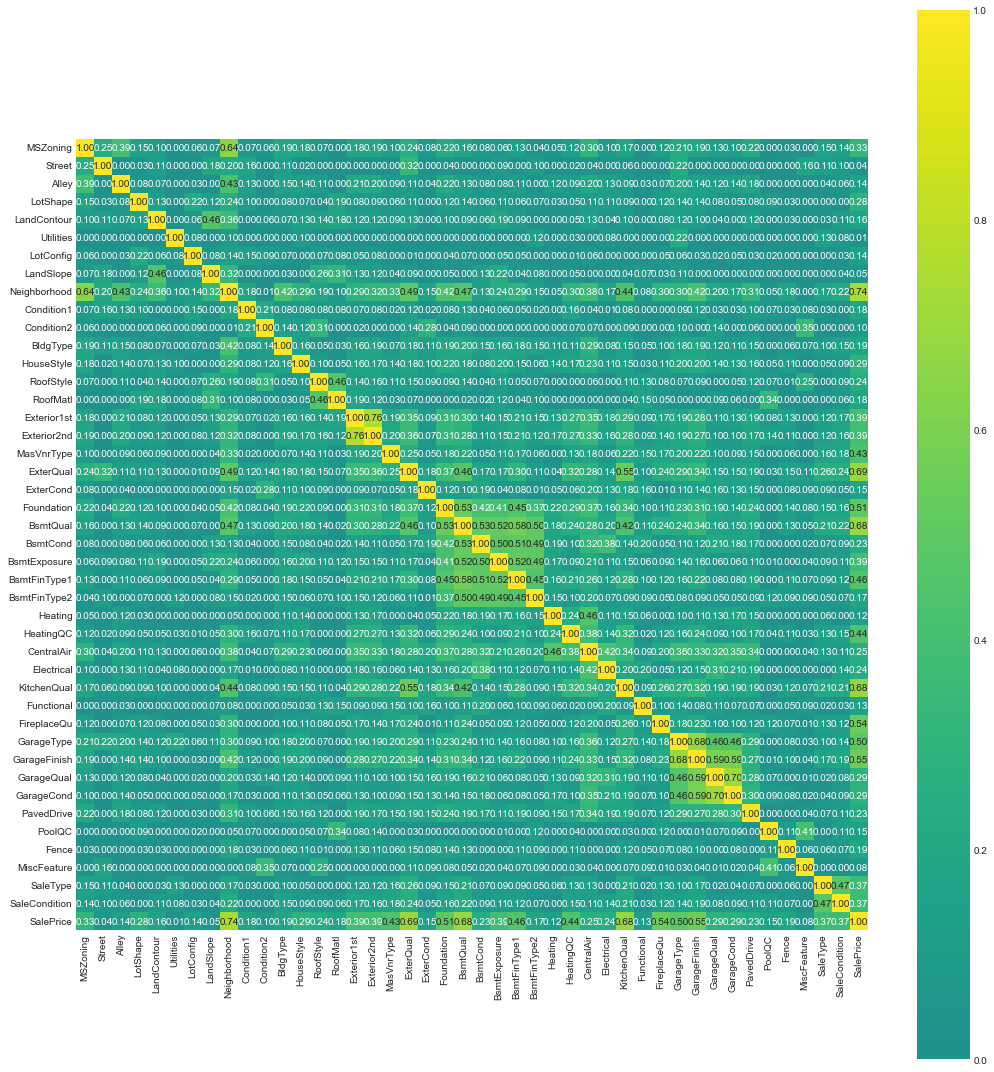

In [39]:
fig,ax = plt.subplots(figsize=(15,15))
associations(dataset=train[(cats_train.to_list() +['SalePrice'])],numerical_columns='SalePrice',nan_replace_value='missing',cmap='viridis',mark_columns=False,ax=ax,)
fig.savefig("Categorical Features kaggle house predictions.png")